# Artificial Intelligence and Machine Learning <a class="tocSkip">


## Unit II <a class="tocSkip">

## Eigendecomposition, Principal Component Analysis (PCA), 3DMM
    
    
**Iacopo Masi**

## My own latex definitions
$$\gdef\mbf#1{\mathbf{#1}}$$



In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#plt.style.use('seaborn-whitegrid')

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 12}

# Use this font if you don't have Times New Roman
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


# Aux functions

def plot_grid(Xs, Ys, axs=None):
    ''' Aux function to plot a grid'''
    t = (np.arange(Xs.size)) # define progression of int for indexing colormap
    if axs:
        axs.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        axs.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        axs.axis('scaled') # axis scaled
    else:
        plt.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        plt.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        plt.axis('scaled') # axis scaled
        
def linear_map(A, Xs, Ys):
    '''Map src points with A'''
    # [NxN,NxN] -> NxNx2 # add 3-rd axis, like adding another layer
    src = np.stack((Xs,Ys), axis=Xs.ndim)
    # flatten first two dimension
    # (NN)x2
    src_r = src.reshape(-1,src.shape[-1]) #ask reshape to keep last dimension and adjust the rest
    # 2x2 @ 2x(NN)
    dst = A @ src_r.T # 2xNN
    #(NN)x2 and then reshape as NxNx2
    dst = (dst.T).reshape(src.shape)
    # Access X and Y
    return dst[...,0], dst[...,1]


def plot_points(ax, Xs, Ys, col='red', unit=None, linestyle='solid'):
    '''Plots points'''
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='gray', linestyle="--")
    ax.axvline(x=0, color='gray',  linestyle="--")
    ax.plot(Xs, Ys, color=col)
    if unit is None:
        plotVectors(ax, [[0,1],[1,0]], ['gray']*2, alpha=1, linestyle=linestyle)
    else:
        plotVectors(ax, unit, [col]*2, alpha=1, linestyle=linestyle)

def plotVectors(ax, vecs, cols, alpha=1, linestyle='solid'):
    '''Plot set of vectors.'''
    for i in range(len(vecs)):
        x = np.concatenate([[0,0], vecs[i]])
        ax.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha, linestyle=linestyle, linewidth=2)
        
def angle(v, w):
    return np.arccos(v.dot(w) / (np.linalg.norm(v) * np.linalg.norm(w)))

# let's see it with numpy
nX, nY, res = 10, 10, 21 # boundary of our space + resolution
X = np.linspace(-nX, +nX, res) # give me 21 points linear space from -10, +10 
Y = np.linspace(-nX, +nX, res) # give me 21 points linear space from -10, +10
# meshgrid is very useful to evaluate functions on a grid
# z = f(X,Y)
# please see https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html
Xs, Ys = np.meshgrid(X, Y) #NxN, NxN

# Slide Correction

## First send the PR on Github
## Then, only after the PR is approved and accepted fill the form


PR = Pull Request

# Recap the previous lecture
- Vector and Matrix as a formal way to represent data
- Why LA? (data, covariance matrix, calculus)
- Operations (vector to vector, matrix to vector, inner product)
- Geometric Interpretation of the inner product
- Subspaces/Rank/Inverse
- Projection onto a subspace

# This lecture material is taken from
- ### Note: <ins> you can find PCA on Chapter 12 of [Bishop Book] </ins>
- [Geometry of the Transformations](https://en.wikipedia.org/wiki/Geometric_transformation)
- [Geometry of Transformations take 2](https://math.hmc.edu/calculus/hmc-mathematics-calculus-online-tutorials/linear-algebra/geometry-of-linear-transformations/)
- [This pdf covers this part](http://cs229.stanford.edu/summer2019/cs229-linalg.pdf)
- [Illustrations and some math parts are taken from d2l.ai, eigendecomposition](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/eigendecomposition.html)
- [Code for Eigendecomposition](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.7-Eigendecomposition/)

## Determinant
The geometric view of linear algebra gives an intuitive way
to interpret a fundamental quantity known as the *determinant*.
Consider the grid image from before, but now with a highlighted region below.

<img src="https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/grid-transform-filled.svg" />

Look at the highlighted square.  This is a square with edges given
by $(0, 1)$ and $(1, 0)$ and thus it has area one.
After $\mathbf{A}$ transforms this square,
we see that it becomes a parallelogram.
There is no reason this parallelogram should have the same area
that we started with, and indeed in the specific case shown here of

$$
\mathbf{A} = \begin{bmatrix}
1 & 2 \\
-1 & 3
\end{bmatrix},
$$

it is an exercise in coordinate geometry to compute
the area of this parallelogram and obtain that the area is $5$.

In general, if we have a matrix

$$
\mathbf{A} = \begin{bmatrix}
a & b \\
c & d
\end{bmatrix},
$$

we can see with some computation that the area
of the resulting parallelogram is $ad-bc$.
This area is referred to as the *determinant*.

## Determinant $\rightarrow$ Hyper-volume ratio

![The matrix $\mathbf{A}$ again distorting the grid.  This time, I want to draw particular attention to what happens to the highlighted square.](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/grid-transform-filled.svg)

**Sanity Check:** We cannot apply Pythagoras' Theorem to compute area because axes are not aligned anymore.

The picture is misleading since the axes are **CLOSED to be aligned**.

The angle between $[1, -1]$ and $[2,3]$ is 101.30993247402021
```python import numpy as np; X = np.array([[1, -1], [2, 3]]);thetarad = angle(X[0,:],X[1,:]);theta = thetarad*180/np.pi; print(theta)}}
```

The angle between $[1, 0]$ and $[0, 1]$ is 90.

```python
is_basis = False
X = np.array([[1, 0], [0, 1]]) if is_basis else np.array([[1, -1], [2, 3]])
theta_rad = angle(*X)
theta = theta_rad*180/np.pi
print(theta_rad)
```

# Transformations of Linear Maps

## No transformation! Identity matrix

## Translation or Displacement (for now let's leave it a side)

**Preserve distances and oriented angles**

<img src="https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/par-vec.svg" width="30%">

## Isometries (Euclidean): Rotation and Translations

**Preserve angles and distances**

$$A = \left[\begin{array}{cc}\cos\theta ~~~ -\sin\theta \\\sin\theta ~~~ \cos\theta\end{array} \right]$$

This is easily derived by noting that

<img src='figs/rotation.png' />

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


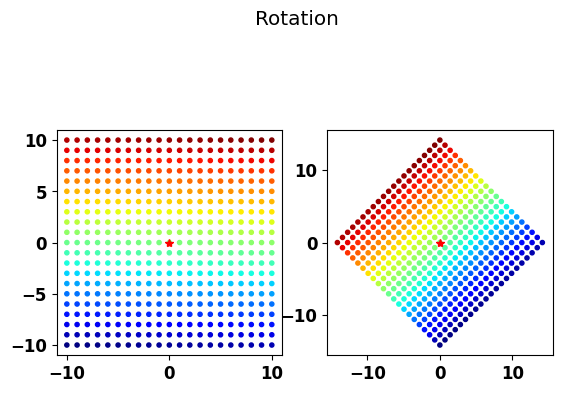

In [2]:

ang = np.pi/4
A = np.array([[np.cos(ang), -np.sin(ang)],
              [np.sin(ang),np.cos(ang)]])
print(A)
Xd, Yd = linear_map(A, Xs, Ys)
fig, axs = plt.subplots(1,2)
fig.suptitle('Rotation')
plot_grid(Xs,Ys,axs[0])
plot_grid(Xd,Yd,axs[1])

## Similarity (Euclidean): scale, reflection (flip), Rotation and Translations

**Preserve angles and RATIO between distances**

$$A = \left[\begin{array}{cc}s_x\cos\theta ~~~ -\sin\theta \\\sin\theta ~~~ s_y\cos\theta\end{array} \right]$$

This is easily derived by noting that

<img src='figs/scale_rotation.png' />

[[ 1.41421356 -0.70710678]
 [ 0.70710678  1.41421356]]


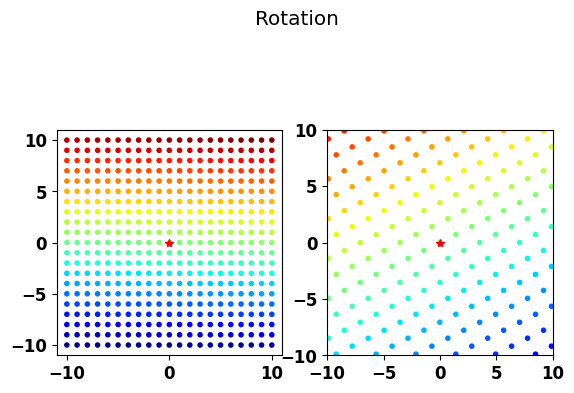

In [3]:
ang, scale, clip = np.pi/4, 2, True
A = np.array([[scale*np.cos(ang), -np.sin(ang)],
              [np.sin(ang), scale*np.cos(ang)]])
print(A)
Xd, Yd = linear_map(A, Xs, Ys)
fig, axs = plt.subplots(1, 2)
fig.suptitle('Rotation')
plot_grid(Xs, Ys, axs[0])
plot_grid(Xd, Yd, axs[1])
if clip:
    plt.xlim(-nX, nX)
    plt.ylim(-nY, nY)

## Affine: shear, scale, reflection (flip), Rotation and Translations

**Preserve parallelism (but NOT angles!)**

$$A = \left[\begin{array}{cc}s_x\cos\theta ~~~ -c_x\sin\theta \\c_y\sin\theta ~~~ s_y\cos\theta\end{array} \right]$$

This is easily derived by noting that

<img src='figs/scale_shear_rotation.png' />

[[ 1.41421356 -5.65685425]
 [ 1.41421356  1.41421356]]


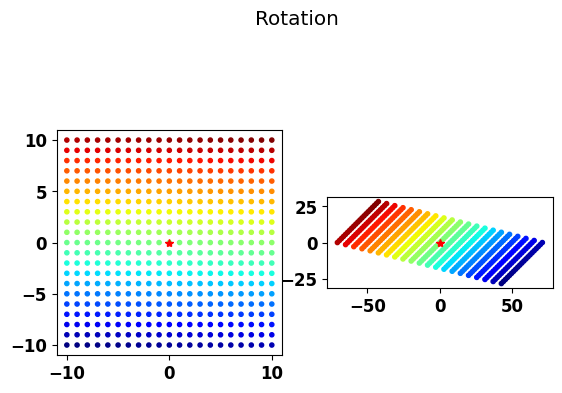

In [4]:
ang, scale, cx_shear, cy_shear,clip = np.pi/4, 2, 8, 2, False
A = np.array([[scale*np.cos(ang), -cx_shear*np.sin(ang)],
              [cy_shear*np.sin(ang), scale*np.cos(ang)]])
print(A)
Xd, Yd = linear_map(A, Xs, Ys)
fig, axs = plt.subplots(1, 2)
fig.suptitle('Rotation')
plot_grid(Xs, Ys, axs[0])
plot_grid(Xd, Yd, axs[1])
if clip:
    plt.xlim(-nX, nX)
    plt.ylim(-nY, nY)

# Hyperplanes

**Hyperplane**: a generalization to higher dimensions of a line ($D=2$) or of a plane ($D=3$).
In a $d$-dimensional vector space, a hyperplane has $d-1$ dimensions and **divides the space into two half-spaces.**

$$ \mathbf{w}\mathbf{x} + \mathbf{b} = 0 $$
where $\mathbf{w}$ is a vector normal to the hyperplane and $\mathbf{b}$ is an offset

<img width='30%' src='https://d2l.ai/_images/space-division.svg' />

# Hyperplanes

**Hyperplane**: a generalization to higher dimensions of a line ($D=2$) or of a plane ($D=3$).
In an $d$-dimensional vector space, a hyperplane has $d-1$ dimensions and **divides the space into two half-spaces.**

$$ \mathbf{w}\mathbf{x} + \mathbf{b} = 0$$
where $\mathbf{w}$ is a vector normal to the hyperplane and $\mathbf{b}$ is an offset

<img width='30%' src='https://d2l.ai/_images/space-division-3d.svg' />

# Projection

Suppose that we have two vectors $\mathbf{v}$ and a column vector $\mathbf{w}=[2,1]^\top$.  

**We want to project $\mathbf{v}$ onto $\mathbf{w}$ or better project v onto the subspace (line in this case) of $\mathbf{w}$.**

Recalling trigonometry, we see the formula $\|\mathbf{v}\|\cos(\theta)$ is the length of the projection of the vector $\mathbf{v}$ onto the direction of $\mathbf{w}$

<img width='30%' src="https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/proj-vec.svg" />

## Projection vector onto subspace defined by $\mathbf{w}$

$$\mathbb{P}_\mathbf{w}(\mathbf{v}) = \frac{\mathbf{w}\mathbf{w}^T}{\mathbf{w}^T\mathbf{w}}\mathbf{v} = \left( \frac{\mathbf{w}}{||\mathbf{w}||}\right)\left(\frac{\mathbf{w}}{||\mathbf{w}||}\right)^T\mathbf{v}$$

Defining a unit vector $\mathbf{\hat{w}}=\frac{\mathbf{w}}{||\mathbf{w}||}$ we have:
$$\mathbb{P}_\mathbf{w}(\mathbf{v}) =  \underbrace{\mathbf{\hat{w}}}_{\text{direction}} \left(\underbrace{\mathbf{\hat{w}}^T \mathbf{v}}_{\text{length}}\right)$$

- Projection must be on unit vector $\alpha\cdot\mathbf{\hat{w}}$
- How long in this direction? $\alpha=\mathbf{\hat{w}}^T \mathbf{v}$ that gives the length of **v** onto **w**.
- **$\mathbf{w}$** can be also a matrix, not a vector (a matrix in which columns are vectors).

# This lecture material is taken from
- [Geometry of the Transformations](https://en.wikipedia.org/wiki/Geometric_transformation)
- [Geometry of Transformations take 2](https://math.hmc.edu/calculus/hmc-mathematics-calculus-online-tutorials/linear-algebra/geometry-of-linear-transformations/)
- [This pdf covers this part](http://cs229.stanford.edu/summer2019/cs229-linalg.pdf)
- [Illustrations and some math parts are taken from d2l.ai, eigendecomposition](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/eigendecomposition.html)
- [Code for Eigendecomposition](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.7-Eigendecomposition/)

# Today's lecture
## Decomposition (Eigen, SVD), PCA (we use projection!)
## Applications of PCA
## Recap on Calculus

## ⚠️ All the examples are in 2D but generalizes to 3D and N-D

- Machine Learning is about thinking in N-dimensional space
- ...especially for vision problems (images, videos)
- 2D is used for the sake of visualization and clarity in the explanation

# Eigendecomposition

Suppose that we have a matrix $A$ with the following entries:

$$
\mathbf{A} = \begin{bmatrix}
2 & 0 \\
0 & -1
\end{bmatrix}.
$$

If we apply $A$ to any vector $\mathbf{v} = [x, y]^\top$, 
we obtain a vector $\mathbf{A}\mathbf{v} = [2x, -y]^\top$.
This has an intuitive interpretation:
stretch the vector to be twice as wide in the $x$-direction,
and then flip it in the $y$-direction.

**However, there are *some* vectors for which something remains unchanged.**

Namely $[1, 0]^\top$ gets sent to $[2, 0]^\top$
and $[0, 1]^\top$ gets sent to $[0, -1]^\top$.

These vectors are still in the same line,
and the only modification is that the matrix stretches them
by a factor of $2$ and $-1$ respectively.
**We call such vectors *eigenvectors*
and the factor they are stretched by *eigenvalues*.**

In general, if we can find a number $\lambda$ 
and a vector $\mathbf{v}$ such that 

$$
\underbrace{\mathbf{A}}_{\text{known}}\mathbf{v} = \underbrace{\lambda\mathbf{v}}_{\text{unknown}}
$$

We say that $\mathbf{v}$ is an eigenvector for $A$ and $\lambda$ is an eigenvalue.

## Finding Eigenvalues
$$(\mathbf{A} - \lambda \mathbf{I})\mathbf{v} = 0.$$


For the equation to happen, we see that $(\mathbf{A} - \lambda \mathbf{I})$ 
must compress some direction down to zero, 
hence it is not invertible, and thus the determinant is zero.
Thus, we can find the *eigenvalues* 
by finding for what $\lambda$ is $\det(\mathbf{A}-\lambda \mathbf{I}) = 0$.
Once we find the eigenvalues, we can solve 
$\mathbf{A}\mathbf{v} = \lambda \mathbf{v}$ 
to find the associated *eigenvector(s)*.

### An Example
Let's see this with a more challenging matrix

$$
\mathbf{A} = \begin{bmatrix}
2 & 1\\
2 & 3 
\end{bmatrix}.
$$

If we consider $\det(\mathbf{A}-\lambda \mathbf{I}) = 0$, 
we see this is equivalent to the polynomial equation
$0 = (2-\lambda)(3-\lambda)-2 = (4-\lambda)(1-\lambda)$.
Thus, two eigenvalues are $4$ and $1$.
To find the associated vectors, we then need to solve

$$
\begin{bmatrix}
2 & 1\\
2 & 3 
\end{bmatrix}\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}1x \\ 1y\end{bmatrix}  \; \text{and} \;
\begin{bmatrix}
2 & 1\\
2 & 3 
\end{bmatrix}\begin{bmatrix}x \\ y\end{bmatrix}  = \begin{bmatrix}4x \\ 4y\end{bmatrix} .
$$

We can solve this with the vectors $[1, -1]^\top$ and $[1, 2]^\top$ respectively.

In [5]:
eigs, eigvects = np.linalg.eig(
                 np.array([[2, 1],
                           [2, 3]]))
print(f'Eigen val:\n {eigs}', end='\n\n')
print(f'EigenVect vect:\n {eigvects}')
# Note that `numpy` normalizes the eigenvectors to be of length one,
# whereas we took ours to be of arbitrary length.
# Additionally, the choice of sign is arbitrary.
# However, the vectors computed are parallel 
# to the ones we found by hand with the same eigenvalues.
#help(np.linalg.eig)

Eigen val:
 [1. 4.]

EigenVect vect:
 [[-0.70710678 -0.4472136 ]
 [ 0.70710678 -0.89442719]]


# Geometric Interpretation of Eigenvectors

# Parametric Unit Sphere

\begin{equation}
\Big\{ t \in [0,2\pi]~~|~~ x=\cos(t),y=\sin(t) \Big\}
\end{equation}

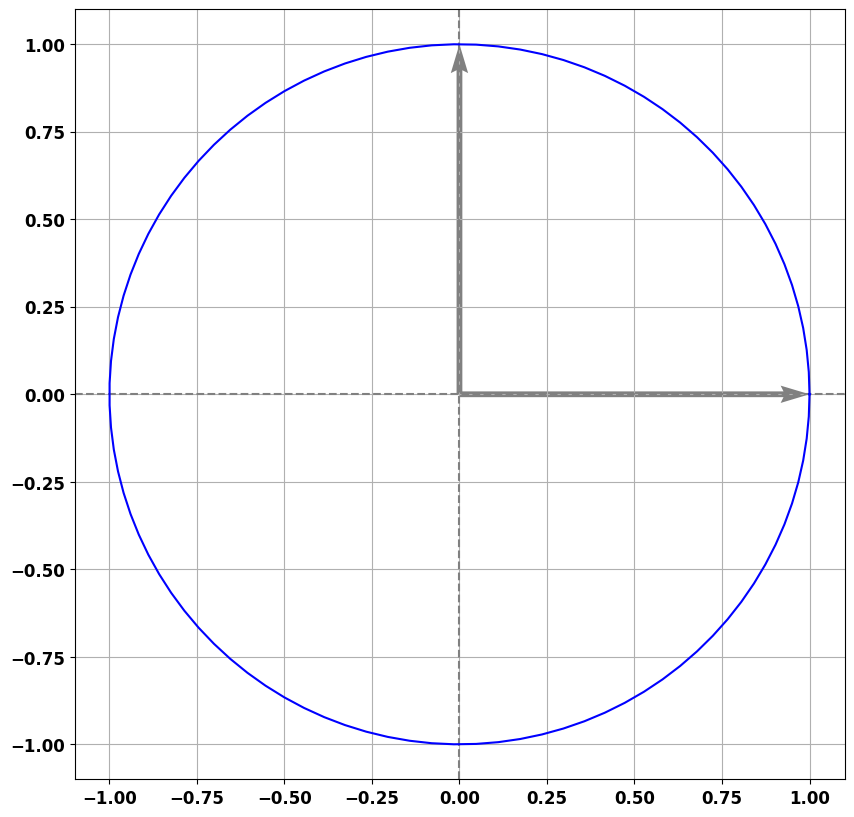

In [6]:
fig_dim = 10
### Unit Sphere
# Parametric sphere
t = np.linspace(0, 2*np.pi, 100) # seems a circle but it is not (move resolution to 10)
Xs = np.cos(t)
Ys = np.sin(t)

# Plot
fig, ax = plt.subplots()
fig.set_figheight(fig_dim)
fig.set_figwidth(fig_dim)
plot_points(ax, Xs, Ys, col='blue')
plt.show()

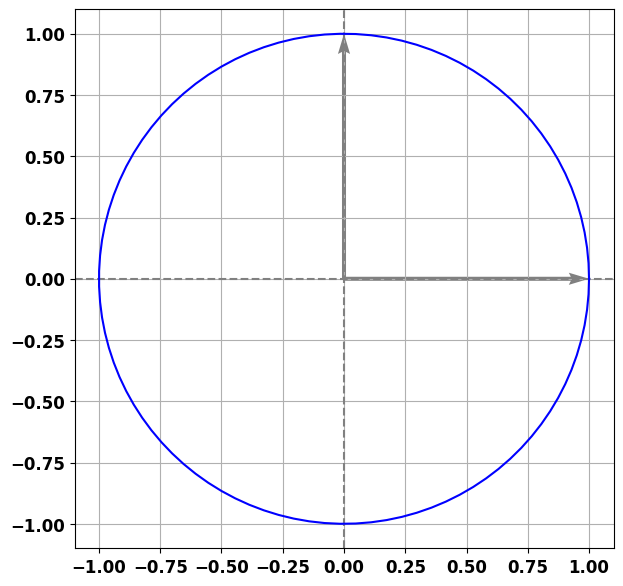

In [7]:
fig_dim = 7
### Unit Sphere
# Parametric sphere
t = np.linspace(0, 2*np.pi, 100) # seems a circle but it is not (move resolution to 10)
Xs = np.cos(t)
Ys = np.sin(t)

# Plot
fig, ax = plt.subplots()
fig.set_figheight(fig_dim)
fig.set_figwidth(fig_dim)
plot_points(ax, Xs, Ys, col='blue')
plt.show()

# Linear Transform to Unit Sphere
- For each point $\mathbf{p}=(x,y)$ apply the transform $\mathbf{A}\mathbf{p}^T$
- Plot the result
- We can do it without using for loop (we used it in the previous lecture)
    - by stacking all **p** column-wise into a matrix **P**
    - then doing `A@P`
    
- For now, assume:
  - `A` is square

In [8]:
# Define a transform
limit = 2.5
# Define a transformation
# A = np.array([[1.5, 1], 
#               [1, 1.5]])
A = np.array([[1, -1], 
              [-1, 2]])
print(f'Transformation is\n {A}')

Transformation is
 [[ 1 -1]
 [-1  2]]


In [9]:
# Map points on the surface
Xd, Yd = linear_map(A, Xs, Ys)
# let's map the basis
Xu_d, Yu_d = linear_map(A, np.array([1,0]), np.array([0,1]))
units_d = np.stack((Xu_d, Yu_d),axis=1)
# Compute the eigenvalues and eigenvectors
eigVals, eigVecs = np.linalg.eig(A)
print('eigVals', eigVals, 'eigVecs', eigVecs, sep='\n'*2)

eigVals

[0.38196601 2.61803399]

eigVecs

[[-0.85065081  0.52573111]
 [-0.52573111 -0.85065081]]


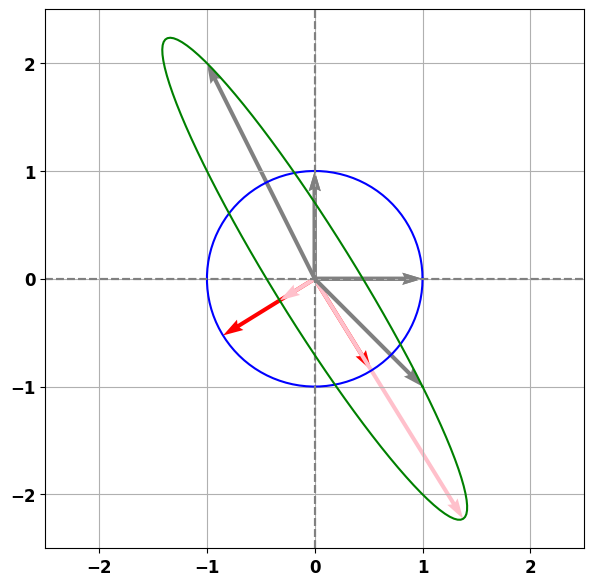

In [10]:
# Plot src points and destination points
fig, ax = plt.subplots(1,1)
fig.set_figheight(fig_dim)
fig.set_figwidth(fig_dim)
# Plot src
plot_points(ax, Xs, Ys, col='blue')
# Plot destination
plot_points(ax, Xd, Yd, col='green')
ax.set_aspect('equal')
ax.set_xlim(-limit,limit)
ax.set_ylim(-limit,limit)
# Plot normalized eigenvectors (unit 1)
plotVectors(ax, [eigVecs[:,0], eigVecs[:,1]],
            cols=['red']*2)
# Plot unnormalized eigenvectors (unit 1)
# we have to multiply back to its own eig val
plotVectors(ax, [eigVals[0]*eigVecs[:,0], eigVals[1]*eigVecs[:,1]],
            cols=['pink']*2)
plotVectors(ax, [Xu_d, Yu_d ],
            cols=['gray']*2)

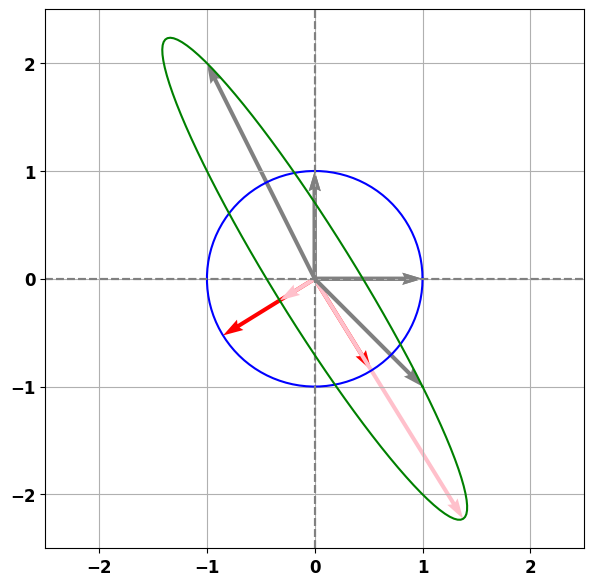

In [11]:
# Plot src points and destination points
fig, ax = plt.subplots(1,1)
fig.set_figheight(fig_dim)
fig.set_figwidth(fig_dim)
# Plot src
plot_points(ax, Xs, Ys, col='blue')
# Plot destination
plot_points(ax, Xd, Yd, col='green')
ax.set_aspect('equal')
ax.set_xlim(-limit,limit)
ax.set_ylim(-limit,limit)
# Plot normalized eigenvectors (unit 1)
plotVectors(ax, [eigVecs[:,0], eigVecs[:,1]],
            cols=['red']*2)
# Plot unnormalized eigenvectors (unit 1)
# we have to multiply back to its own eig val
plotVectors(ax, [eigVals[0]*eigVecs[:,0], eigVals[1]*eigVecs[:,1]],
            cols=['pink']*2)
plotVectors(ax, [Xu_d, Yu_d ],
            cols=['gray']*2)

## Interpretations of the determinant with Eigendecomposition
- Symmetric if $A = A^T$ so we can compute eigenvalues
- **The determinant of a matrix is the product of the eigenvalues**
    - So determinant does not capture change in directions (consider only eigenvalues)
    - Just change in the "hyper-volume" (area in 2D).
- **The determinant can be considered as the ratio between**
 - Volume of destination shape/volume of the source shape
 - Ratio of area between the ellipse and circle is `np.prod(eigVals)` = {{np.prod(eigVals)}}

## Eigendecomposition of Matrices
$$
\mathbf{W} = \begin{bmatrix}
1 & 1 \\
-1 & 2
\end{bmatrix},
$$

be the matrix where the columns are the eigenvectors of the matrix $\mathbf{A}$. Let

$$
\boldsymbol{\Sigma} = \begin{bmatrix}
1 & 0 \\
0 & 4
\end{bmatrix},
$$

be the matrix with the associated eigenvalues on the diagonal.
Then the definition of eigenvalues and eigenvectors tells us that

$$
\mathbf{A}\mathbf{W} =\mathbf{W} \boldsymbol{\Sigma} .
$$

The matrix $W$ is invertible, so we may multiply both sides by $W^{-1}$ on the right,
we see that we may write

$$\mathbf{A} = \mathbf{W} \boldsymbol{\Sigma} \mathbf{W}^{-1}.$$

if $\mathbf{W}$ is invertible

## Operations on Eigendecompositions
One nice thing about eigendecompositions is that 
we can write many operations we usually encounter cleanly 
in terms of the eigendecomposition. As a first example, consider:

$$
\mathbf{A}^n = \overbrace{\mathbf{A}\cdots \mathbf{A}}^{\text{$n$ times}} = \overbrace{(\mathbf{W}\boldsymbol{\Sigma} \mathbf{W}^{-1})\cdots(\mathbf{W}\boldsymbol{\Sigma} \mathbf{W}^{-1})}^{\text{$n$ times}} =  \mathbf{W}\overbrace{\boldsymbol{\Sigma}\cdots\boldsymbol{\Sigma}}^{\text{$n$ times}}\mathbf{W}^{-1} = \mathbf{W}\boldsymbol{\Sigma}^n \mathbf{W}^{-1}.
$$

This tells us that for any positive power of a matrix,
the eigendecomposition is obtained by just raising the eigenvalues to the same power.
The same can be shown for negative powers,
so if we want to invert a matrix we need only consider

$$
\mathbf{A}^{-1} = \mathbf{W}\boldsymbol{\Sigma}^{-1} \mathbf{W}^{-1},
$$
or in other words, just invert each eigenvalue.

# Spectral Theorem

Informal: Given a matrix $\mathbf{A}$ **squared and symmetric**, $\mathbf{A} \in \mathbb{R}^{d\times d}$ and $\mathbf{A} = \mathbf{A}^T$ then:

- All the eigenvalues take **real values**
- The eigenvectors are all **orthogonal**

### Practical applications:
- Hessian, Covariance Matrices
- Kernel matrices

## Eigendecompositions of Symmetric Matrices

- Hessian 
- Covariance Matrices
- PCA
- Kernels etc

# Eigendecomposition and Singular Value Decomposition
<br>
<img src='figs/table_svd.png' width='40%'/>


# Decomposition as a Geometric Pipeline

$$\mathbf{A}\mathbf{x} = \underbrace{(\mathbf{U} 
\underbrace{(\mathbf{\Sigma}\underbrace{(\mathbf{U}^{-1}\mathbf{x})}_{\text{1st step/rotate}})}_{\text{2nd step/scale}})}_{\text{3rd step/rotate}}$$

<img src='figs/table_svd_2.png' width='40%'/>

# Decomposition as a Geometric Pipeline (Code)

In [12]:
print('A', A, sep='\n\n')
Sigma, U = np.diag(eigVals), eigVecs
print('Sigma', Sigma, 'U', U, sep='\n\n')

A

[[ 1 -1]
 [-1  2]]
Sigma

[[0.38196601 0.        ]
 [0.         2.61803399]]

U

[[-0.85065081  0.52573111]
 [-0.52573111 -0.85065081]]


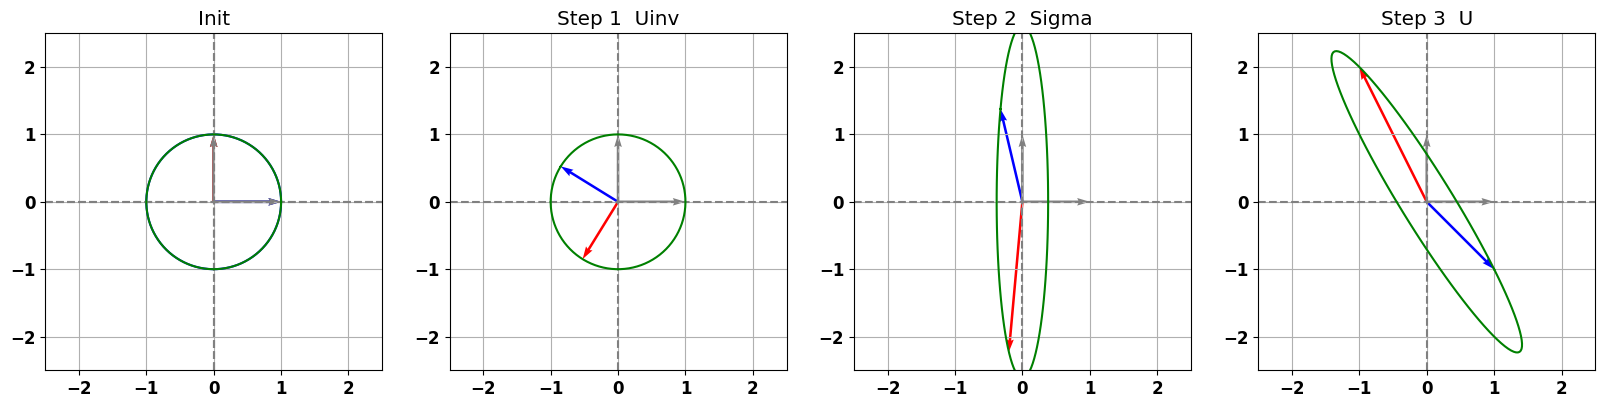

In [13]:
# Plot src points and destination points
fig, axes = plt.subplots(1, 4)
fig.set_figheight(20)
fig.set_figwidth(20)
# apply [Id, Uinv, Sigma, U]
Trans = [np.diag((1, 1)), U.T, Sigma, U]
titles = ['Init', 'Step 1  Uinv', 'Step 2  Sigma', 'Step 3  U']
X_orig = np.array([1, 0])
Y_orig = np.array([0, 1])
Xss = np.copy(Xs)
Yss = np.copy(Ys)
for count, (ax, T, title) in enumerate(zip(axes, Trans, titles)):
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_aspect('equal')
    ax.set_title(title)
    Xss, Yss = linear_map(T, Xss, Yss)
    X_orig, Y_orig = linear_map(T, X_orig, Y_orig)
    if count == 0:
        plot_points(ax, Xs, Ys, col='blue')
    unit_v = np.stack((X_orig, Y_orig), axis=1)
    plotVectors(ax, unit_v, ['blue', 'red'])
    plot_points(ax, Xss, Yss, col='green')

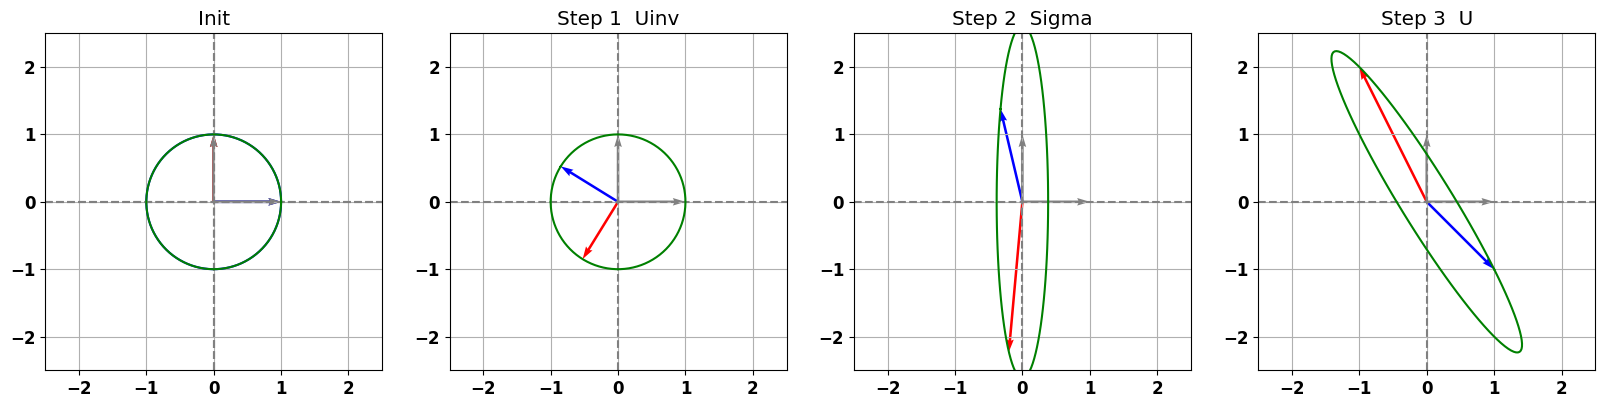

In [14]:
# Plot src points and destination points
fig, axes = plt.subplots(1, 4)
fig.set_figheight(20)
fig.set_figwidth(20)
# apply [Id, Uinv, Sigma, U]
Trans = [np.diag((1, 1)), U.T, Sigma, U]
titles = ['Init', 'Step 1  Uinv', 'Step 2  Sigma', 'Step 3  U']
X_orig = np.array([1, 0])
Y_orig = np.array([0, 1])
Xss = np.copy(Xs)
Yss = np.copy(Ys)
for count, (ax, T, title) in enumerate(zip(axes, Trans, titles)):
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_aspect('equal')
    ax.set_title(title)
    Xss, Yss = linear_map(T, Xss, Yss)
    X_orig, Y_orig = linear_map(T, X_orig, Y_orig)
    if count == 0:
        plot_points(ax, Xs, Ys, col='blue')
    unit_v = np.stack((X_orig, Y_orig), axis=1)
    plotVectors(ax, unit_v, ['blue', 'red'])
    plot_points(ax, Xss, Yss, col='green')

# Geometry of SVD 

Source: Wikipedia
<img width='50%' src="https://upload.wikimedia.org/wikipedia/commons/b/bb/Singular-Value-Decomposition.svg" />

<img width='40%' src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Singular_value_decomposition.gif/280px-Singular_value_decomposition.gif" />

# Principal Component Analysis (PCA)

### PCA works in unsupervised learning settings

\begin{equation}
 \underbrace{\{\mathbf{x}_i\}_{i=1}^N}_{\text{known}} \sim \underbrace{\mathcal{D}}_{\text{unknown}}
\end{equation}

### Assumptions

- $\mathbf{x}_i \in \mathbb{R}^D$ 
- $N \geq D$ (number of points higher than number of features; or else, more points than dimensions..for now...)
- $D \geq k$ (where k is the dimension of the subspace on which we will project the points | number of components we will take)

### Objective: find a transformation for compressing the data.
### What does it mean compressing data? Maybe have different meanings
### Which kind of transformation?

In [15]:
########### We know the generative model of the data D ############
np.random.seed(0) # fixing the seed
n_samples=100; cov = [[3, 3], [3, 4]]
# Assumes know the generative model of data
X = np.random.multivariate_normal(mean=[1, 1], cov=cov, size=n_samples)
###########################################################

In [16]:
# import pandas as pd
# pd.DataFrame(X, columns=["x", "y"])

num of points 100 in dimension 2


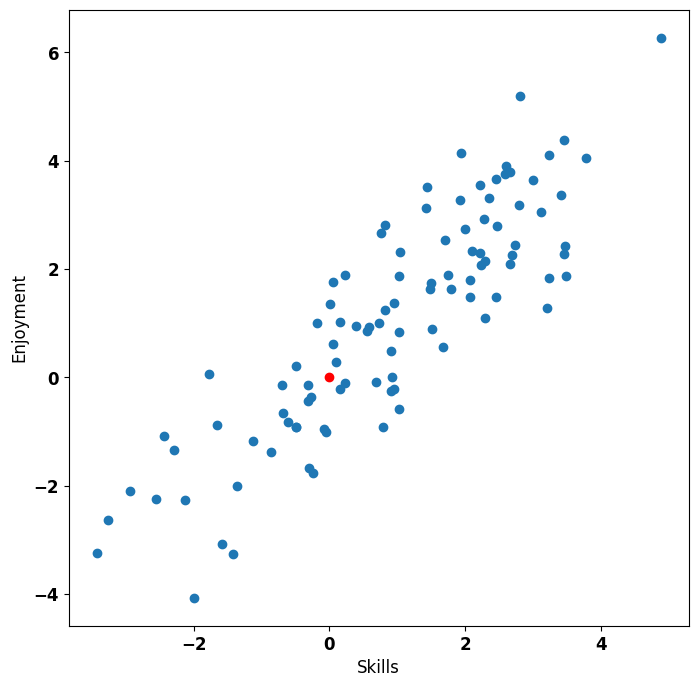

In [17]:
print(f'num of points {X.shape[0]} in dimension {X.shape[1]}')
fig = plt.figure(figsize=(8,8))
plt.scatter(*X.T) 
plt.scatter(0, 0, c='r', marker='o')
plt.ylabel('Enjoyment')
_ = plt.xlabel('Skills')

<img width='40%' src=data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZYAAAF4CAYAAAB3tt9kAAAKrmlDQ1BJQ0MgUHJvZmlsZQAASImV%0AlgdUU2kWx7/30hsEEqqU0DvSCSAQOqEI0sFGSCCEEmIgKNgRcQRGFBERUEZ0EETBUSkyFsSCbVBU%0AxD4gg4AyDhawoLIPWMLunp2zZ+87973fuee+m//78n3n/AEgP+SIRCkwFYBUYYY4xMedERUdw8D9%0ADiAgi1wWgMThpovcgoMDwN/GxAOkG4l7ZtOz/r7vv4YcLz6dCwAUjHAcL52bivBpJNu5InEGACgk%0Agc7qDNE0lyFMFyMCET42zfxZbp/muFm+P9MTFuKB8DAAeDKHI+YDQPqA1BmZXD4yh0xH2ELIEwgR%0A9kTYhZvI4SGci7BpamraNJ9A2DDuX+bw/21mnHQmh8OX8uy3zATeU5AuSuFk/Z/L8b8jNUUy9xva%0ASJITxb4hyFMZWbPa5DR/KQvjFgfNsYA30z/DiRLf8DnmpnvEzDGP4+k/x5LkcLc55ojn3xVksMPm%0AWJwWIp0fn+4VKp0fzw6QakhZLOUEgTd7jrMTwyLnOFMQsXiO05ND/ed7PKR1sSREqjlB7C39xtT0%0AeW1czryGjMQw33ltUVINvHhPL2ldGC7tF2W4S2eKUoKl/fEpPtJ6emao9N0MZIPNcRLHL3h+TrB0%0AfYAn8AIByMUA4cAKWANL5O4LAjPi10zvaeCRJsoSC/iJGQw35NTEM9hCrrkpw8rC0haA6TM4+xe/%0AfzhztiBF/HwtTQkA5p/IXnw2X4ttBuDUGABU6nzNgAAATQeACyyuRJw5W0NP3zCAiJxtOlABGkAH%0AGAIzRJkdcAIsRLEfCAJhIBqsAFyQCFKBGKwG68BmkAcKwE6wB5SDKnAI1ILj4CRoAWfBRXAV3AR3%0AQA94AvrAIHgNxsAEmIQgCAdRIBqkAmlCepAJZAUxIRfICwqAQqBoKBbiQ0JIAq2DtkAFUDFUDh2E%0A6qBfoDPQReg61A09gvqhEegd9AVGwWSYDqvD+vBCmAm7wf5wGLwc5sOr4Gw4F94Bl8HV8DG4Gb4I%0A34R74D74NTyOAigSShGlhTJDMVEeqCBUDCoBJUZtQOWjSlHVqAZUG6oTdQ/VhxpFfUZj0TQ0A22G%0AdkL7osPRXPQq9AZ0IbocXYtuRl9G30P3o8fQ3zEUjBrGBOOIYWOiMHzMakwephRTg2nCXMH0YAYx%0AE1gsVhFrgLXH+mKjsUnYtdhC7H5sI7Yd240dwI7jcDgVnAnOGReE4+AycHm4fbhjuAu4u7hB3Cc8%0ACa+Jt8J742PwQnwOvhR/FH8efxc/hJ8kUAl6BEdCEIFHyCIUEQ4T2gi3CYOESaIc0YDoTAwjJhE3%0AE8uIDcQrxKfE9yQSSZvkQFpCEpA2kcpIJ0jXSP2kz2R5sjHZg7yMLCHvIB8ht5Mfkd9TKBR9CosS%0AQ8mg7KDUUS5RnlM+ydBkzGXYMjyZjTIVMs0yd2XeyBJk9WTdZFfIZsuWyp6SvS07SiVQ9akeVA51%0AA7WCeobaSx2Xo8lZygXJpcoVyh2Vuy43LI+T15f3kufJ58ofkr8kP0BD0XRoHjQubQvtMO0KbZCO%0ApRvQ2fQkegH9OL2LPqYgr2CjEKGwRqFC4ZxCnyJKUV+RrZiiWKR4UvGB4hcldSU3pXil7UoNSneV%0APiovUGYpxyvnKzcq9yh/UWGoeKkkq+xSaVF5popWNVZdorpa9YDqFdXRBfQFTgu4C/IXnFzwWA1W%0AM1YLUVurdkjtltq4uoa6j7pIfZ/6JfVRDUUNlkaSRonGeY0RTZqmi6ZAs0TzguYrhgLDjZHCKGNc%0AZoxpqWn5akm0Dmp1aU1qG2iHa+doN2o/0yHqMHUSdEp0OnTGdDV1A3XX6dbrPtYj6DH1EvX26nXq%0AfdQ30I/U36bfoj9soGzANsg2qDd4akgxdDVcZVhteN8Ia8Q0Sjbab3THGDa2NU40rjC+bQKb2JkI%0ATPabdJtiTB1MhabVpr1mZDM3s0yzerN+c0XzAPMc8xbzNwt1F8Ys3LWwc+F3C1uLFIvDFk8s5S39%0ALHMs2yzfWRlbca0qrO5bU6y9rTdat1q/tTGxibc5YPPQlmYbaLvNtsP2m529ndiuwW7EXtc+1r7S%0AvpdJZwYzC5nXHDAO7g4bHc46fHa0c8xwPOn4l5OZU7LTUafhRQaL4hcdXjTgrO3McT7o3OfCcIl1%0A+cmlz1XLleNa7fqCpcPisWpYQ25Gbklux9zeuFu4i92b3D96OHqs92j3RHn6eOZ7dnnJe4V7lXs9%0A99b25nvXe4/52Pqs9Wn3xfj6++7y7WWrs7nsOvaYn73fer/L/mT/UP9y/xcBxgHigLZAONAvcHfg%0A08V6i4WLW4JAEDtod9CzYIPgVcG/LsEuCV5SseRliGXIupDOUFroytCjoRNh7mFFYU/CDcMl4R0R%0AshHLIuoiPkZ6RhZH9kUtjFofdTNaNVoQ3RqDi4mIqYkZX+q1dM/SwWW2y/KWPVhusHzN8usrVFek%0ArDi3UnYlZ+WpWExsZOzR2K+cIE41ZzyOHVcZN8b14O7lvuaxeCW8kXjn+OL4oQTnhOKEYb4zfzd/%0AJNE1sTRxVOAhKBe8TfJNqkr6mByUfCR5KiUypTEVnxqbekYoL0wWXk7TSFuT1i0yEeWJ+lY5rtqz%0AakzsL65Jh9KXp7dm0BGzc0tiKNkq6c90yazI/LQ6YvWpNXJrhGtuZRlnbc8ayvbO/nktei13bcc6%0ArXWb1/Wvd1t/cAO0IW5Dx0adjbkbBzf5bKrdTNycvPm3HIuc4pwPWyK3tOWq527KHdjqs7U+TyZP%0AnNe7zWlb1Q/oHwQ/dG233r5v+/d8Xv6NAouC0oKvhdzCGz9a/lj249SOhB1dRXZFB3Zidwp3Ptjl%0Auqu2WK44u3hgd+Du5hJGSX7Jhz0r91wvtSmt2kvcK9nbVxZQ1rpPd9/OfV/LE8t7KtwrGivVKrdX%0AftzP23/3AOtAQ5V6VUHVl58EPz086HOwuVq/uvQQ9lDmoZeHIw53/sz8ua5Gtaag5tsR4ZG+2pDa%0Ay3X2dXVH1Y4W1cP1kvqRY8uO3Tnueby1wazhYKNiY8EJcEJy4tUvsb88OOl/suMU81TDab3TlU20%0ApvxmqDmreawlsaWvNbq1+4zfmY42p7amX81/PXJW62zFOYVzReeJ53PPT13IvjDeLmofvci/ONCx%0AsuPJpahL9y8vudx1xf/KtaveVy91unVeuOZ87ex1x+tnbjBvtNy0u9l8y/ZW02+2vzV12XU137a/%0A3XrH4U5b96Lu83dd716853nv6n32/Zs9i3u6H4Q/eNi7rLfvIe/h8KOUR28fZz6efLLpKeZp/jPq%0As9Lnas+rfzf6vbHPru9cv2f/rRehL54McAde/5H+x9fB3JeUl6VDmkN1w1bDZ0e8R+68Wvpq8LXo%0A9eRo3p9yf1a+MXxz+i/WX7fGosYG34rfTr0rfK/y/sgHmw8d48HjzydSJyY/5n9S+VT7mfm580vk%0Al6HJ1V9xX8u+GX1r++7//elU6tSUiCPmzFgBFJJwQgIA744AQIlGvMIdAIgysx55JqBZXz9D4O94%0A1kfPhB0Ah1gAhG0CIKgdgCrkqY+kHJLB03UWgK2tpfnPSE+wtpqdRWpBrEnp1NR7xBvijAD41js1%0ANdkyNfWtBhH7GID2iVlvPh1UxP+zxLb2zICbre/GwX/EPwCnzwa9pJZ3AgAAAZ1pVFh0WE1MOmNv%0AbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1w%0AdGs9IlhNUCBDb3JlIDUuNC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3Lncz%0ALm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiBy%0AZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9l%0AeGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+NDA2PC9leGlmOlBpeGVs%0AWERpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxZRGltZW5zaW9uPjM3NjwvZXhpZjpQaXhl%0AbFlEaW1lbnNpb24+CiAgICAgIDwvcmRmOkRlc2NyaXB0aW9uPgogICA8L3JkZjpSREY+CjwveDp4%0AbXBtZXRhPgrl2uFtAABAAElEQVR4AexdB4AURdb+Ns9GdomSs4ACCgYwwAkmjJw5gYIC6q8CCojo%0AyZ0YOLPC6WGEO9E7T09P70x3igEDqKCCAoIkESSHzbszu/u/r2ZqGTbAzO7s0j37Snu7p7u6uuqr%0A5n396r16FVMmCZoUAUVAEVAEFIEIIRAboXK0GEVAEVAEFAFFwCCgxKIvgiKgCCgCikBEEVBiiSic%0AWpgioAgoAoqAEou+A4qAIqAIKAIRRUCJJaJwamGKgCKgCCgCSiz6DigCioAioAhEFAEllojCqYUp%0AAoqAIqAIKLHoO6AIKAKKgCIQUQSUWCIKpxamCCgCioAioMSi74AioAgoAopARBFQYokonFqYIqAI%0AKAKKgBKLvgOKgCKgCCgCEUVAiSWicGphioAioAgoAkos+g4oAoqAIqAIRBQBJZaIwqmFKQKKgCKg%0ACCix6DugCCgCioAiEFEElFgiCqcWpggoAoqAIqDEou+AIqAIKAKKQEQRUGKJKJxamCKgCCgCioAS%0Ai74DioAioAgoAhFFQIklonBqYYqAIqAIKAJKLPoOKAKKgCKgCEQUASWWiMKphSkCioAioAgoseg7%0AoAgoAoqAIhBRBJRYIgqnFqYIKAKKgCKgxKLvgCKgCCgCikBEEVBiiSicWpgioAgoAoqAEou+A4qA%0AIqAIKAIRRUCJJaJwamGKgCKgCCgCSiz6DigCioAioAhEFAEllojCqYUpAoqAIqAIKLHoO6AIKAKK%0AgCIQUQSUWCIKpxamCCgCioAioMSi74AioAgoAopARBFQYokonFqYIqAIKAKKgBKLvgOKgCKgCCgC%0AEUVAiSWicGphioAioAgoAkos+g4oAoqAIqAIRBSB+IiW5tDCysrKwO3tt982NTzzzDMRExNjNodW%0AWaulCCgCioBrEYgRgVvm2tqHUHFLKgUFBejTp4+545tvvkFycrKSSwj4aRZFQBFQBMJFIOqHwkgs%0AXq8XU6dOxapVq8zGY56Lck4N913Q/IqAIqAIRASBqNZYSBwlJSVYt24devfuDWotTNRWlixZgg4d%0AOiAuLk6HxCLyKmkhioAioAj4EYhqjcVqK3fccUc5qbDZJBieU61F/xkoAoqAIhB5BKJWYyGp+Hw+%0AfPLJJzj11FMrDXvReP+///0PAwcORHx8vGotkX+3tERFQBFooAhELbFwCKywsBADBgwAjfUkDxIN%0Akz2mMX/+/PnweDxmSKyBvgPabEVAEVAEIopAVA6FWdvKnDlzDKkQsRNOOKEcOHtMwmEekhDv0aQI%0AKAKKgCJQewSijlgsqezYsQPTpk0zCDVt2hQnnnhiOVo85jkm5mFeJZdyePRAEVAEFIFaIRCVxMIh%0ArxkzZmDr1q0GnKuvvtp4glmk6BXGc0zMM3PmTDNMplqLRUj3ioAioAjUHIGoJZaEhASDCu0oNN7T%0AjmITj3nOTphkXpKREotFSPeKgCKgCNQcgagK6UJisENhI0aMwOGHH45DDjkESUlJZrMw8XdaWhoe%0AeeQRbNmyBcccc0z5UBjvp8eYJkVAEVAEFIGaIRBVxGIhiI2NRWJiIo444giUlpaa0xU1loyMDHAj%0A8TAv79GkCCgCioAiUHsEoopYqGlYUqFGQsIgsXAiJF2MbeJxeno6OARm81tyUW3FoqR7RUARUARq%0AhsBeaVuz+x13F4mBxJGSkmKGv0gs+fn5+8xTYRgXajDMQ2Lhbw3t4riu1AopAoqASxGISmIhWVjC%0AILEUFRXtYzch+ZBIrJbCvEyqrbj0LdZqKwKKgKMQiDpiIbqWIEgY1RnjmYcb89j8juoZrYwioAgo%0AAi5FQC3WLu04rbYioAgoAk5FQInFqT2j9VIEFAFFwKUIKLG4tOO02oqAIqAIOBUBJRan9ozWSxFQ%0ABBQBlyKgxOLSjtNqKwKKgCLgVASUWJzaM1ovRUARUARcioASi0s7TqutCCgCioBTEVBicWrPaL0U%0AAUVAEXApAkosLu04rbYioAgoAk5FQInFqT2j9VIEFAFFwKUIKLG4tOO02oqAIqAIOBUBJRan9ozW%0ASxFQBBQBlyKgxOLSjtNqKwKKgCLgVASUWJzaM1ovRUARUARcioASi0s7TqutCCgCioBTEVBicWrP%0AaL0UAUVAEXApAkosLu04rbYioAgoAk5FQInFqT2j9VIEFAFFwKUIKLG4tOO02oqAIqAIOBUBJRan%0A9ozWSxFQBBQBlyKgxOLSjtNqKwKKgCLgVASUWJzaM1ovRUARUARcioASi0s7TqutCCgCioBTEVBi%0AcWrPaL0UAUVAEXApAkosLu04rbYioAgoAk5FQInFqT2j9VIEFAFFwKUIKLG4tOO02oqAIqAIOBUB%0AJRan9ozWSxFQBBQBlyKgxOLSjtNqKwKKgCLgVASUWJzaM1ovRUARUARcioASi0s7TqutCCgCioBT%0AEVBicWrPaL0UAUVAEXApAkosLu04rbYioAgoAk5FQInFqT2j9VIEFAFFwKUIKLG4tOO02oqAIqAI%0AOBUBJRan9ozWSxFQBBQBlyKgxOLSjtNqKwKKgCLgVATinVoxrZcioAjUDgHfpvmYNPlpbE9JQUp5%0AUSlo07k7jjllCIb0bV9+dt+DQiyd9xr+NvsfeGvJG1iypDd6D+qIwUN+i0svGYp+7bP2zS6/clbP%0Aw9QJ9+CxN4AX5Z7Le6VXyqMnGg4CSiwNp6+1pQ0MgYLN3+CxuXOrbXXv8a/g00cvxD4U4FuPBy7s%0AgMlCEHvTEiz5kNsbeGwyMO2DjbhzcKvA5W14d8bvcMa4p8uzb/f6yo/1oGEioENhDbPftdUNAYGE%0ApPJWzvpkCZYvWYRP3nkRY3r7Ty957CJMfXN9eR7ROzBnZBCpDJ2GdxYsx7p1P2HBO7MxZpA/66tf%0Ab/AfbFuI4THN9yGVoML0sAEjoMTSgDtfm95QEBiGY47phe69+mLAkMvx1MIlGBNo+mOPvYtdgeNd%0AC2djZEDB6T3+DRT8604M6dcd7dt3Rr8hI/DUvAIseGUWJv+mrbkjZ83HMNl7j8cHPy3HrKENBU9t%0A54EQUGI5EEJ6XRE4yAiUlQGl8qek1L/5SsrArVR+l/HiAVMO4A3K5OmFYdMCakvXJkg2lwrxwfPj%0AApmGYe70c+EJusV/6EG/C6/F5f38w2DJh16AT0QTKvjuUQzu3Bp79aNKN+qJBoaA2lgaWIdrc52D%0AAEnBVwpDEr7SUiEKoCRAIDwW3hDiCK2+MTFArHwmxsk+Tg7i5LjIW/3NeQWBcldtAg89havwRsBM%0A0nvKSPSqzCqVKhKf1RkDBlQ6rScUASix6EugCNQDAj5hCa+wiFc0DbuRPETnKH86tRKbKmkiQdds%0AHrMno9hUAsSY36WIlX1egZwwKQU53mLsyotFYnwMipb/HWdMX2KuDBrUB8bHy+sVC4s/XXhK98CR%0A7hSBmiGgxFIz3PQuRWC/CBQLiRT7ylBcUmo0B0sadl9OHBUIw563p+3v/T5MLvoJhXt/zjI5KJFn%0A+9Pf8MKcs3F8Yy9+WfIefv/o3wLne2H8lceaYbbYBJR7hzXP3MdPLJBXd4pA6AgosYSOleZUBKpF%0AgDaPIiETs8kQlCUQ7g05WKaQEvibPy1pVNxX9RCbp+I1SyhVnfeVEwvw3IQr8Nw+mQZixry5OCoD%0A2LzbC0+pD9ZJuKj8aJ8b9IciEDICSiwhQ6UZFYF9EaBWUigkUuAtMXYSXq1IJMEk4j/eO9zF/JYw%0A7J7nwkn7u8+SG8u79HePoU+TRMQkpaNVh8PQ84huyBQtpaTEjJ8hL6+k3Dvsv5//hBuOPFrsNEHD%0AbOFUSvM2eASUWBr8K6AAhIMAh7cKikuETEqNl1aoRGIJwO6DnxlsZwk+X9vjvcRyMa4YdRW6yb92%0Aq+HExAgZiorC37Fi7I9JzsLhhwHvLQPemvU//HBFb7RNjEN6chzilWBq2xUN7n51N25wXa4NDhcB%0ADnNlF/iwZU8xtuUUI7vQJ/aTEvO1Xypf/KUy5ER7hk/OcaMWwK3UeHrR26vUaCalZbKv4r9w6xN+%0A/lx4i/xPNnWQcbjgurGuPl8rnHTZWf6if7gDM/61CrlF/jbvyvMZEuXFXasXYuGKbQeogn6vHgCg%0AqL+sxBL1XawNrAkC1CwKikuxPdeLLdnF2CPEUlQNmVQkkeqIpCb1qIt7gsmNRGNJpscFN6J/4IHP%0AXd0Lt836N9Zs2YEde3Kx7IdvMGvqMDTu0h/TP95cXi1fYSEKZfP5cpCd7T9dmCf+Zb7A+fKcetCQ%0AENBPi4bU29rWAyJAV+C8IhnqElLhUJIZ6qJfsCQ7IZGCmMkOa5Xvg1yHTQYH/bGG+aqqVD4Ul9Ef%0AD732R5x4/m0m20t3XIyX7qh8R0p8nDlZuGIOknuMrJRh8sDWkJBiJs1ako1rNSBlJYyi/YRqLNHe%0Aw9q+kBAoFJvJDtFOtop2kiNDXV47nGX2/mEuO8RFIqlKKwnpQfWaKTHwtFTEh/AJSYJpduwYLF74%0AFiYNO7NSTY8740bM+M83mH5+Z8FIjP4JaQjM36+U157Q2fgWiYa1D+F1a1iAaGsbFgL5YojPFSFJ%0ATaWEmoiQBhO1E0se5RpJ4Fr5F77DoUrtfjl+WHe+1NITErHY5qS2Pg6j/ijbPYXIzisSA38CktOS%0A4UlI8Bv6hWx355chpcVQLBbbknqPWeR0bxFQYrFI6L7BIECiyJehLhIKZ8RbQvFrIkIbcj14IzBu%0AIZOKnRgfH0Jsloo32d9yb0Yj//0xiAkiWgkZI3nyxCHAK15yTdITkMBYMpoUgQACSiz6KjQYBEgW%0AeUIoORLqhLYTSyjBthPmYSrfO9huUp8dZ4i1wqTOOAlIVix4bRNbfZO0BCRJuBhNigARUGLR96BB%0AIMAhr2whFK8M3RjSEIFYcbhLyWT/r4LV2jhEaOfDcA6MTybEbMspRdPURHgS1Wy7fxQbxlUllobR%0Azw22lfTuoquwP+S834aihFK718FqL3ttUH4y2ZZbjGbpQi4JSi61Q9j9dyuxuL8PtQVVIMAZ8pzI%0AWGRmyCuhVAFRrU5ZcmEhJBgm2l22C7k0T08yUZTNSf3TIBFQYmmQ3R69jaZmQg3FzkMpE6GnGkrd%0A9LclFw4h2i1W8N6ypxSb167A8mXfY9iwYWbYzA6d1U1NtFSnIaDE4rQe0frUGAF6eWXLRqM8CYXC%0AriKpsHAjEGv8FL3RYCjYMnHmPtO6tevw9ddfY+HChVi8eBFyc7JxxqD+uOyyyxAXF1dukzGZ9U/U%0AI6DEEvVdHP0N5HDX7nyJ30XDvBJKnXa41Uw2bNhgiGTRokVCJIuxe9fufZ4bF5+AfgNORlFRETwe%0Aj2ot+6AT/T+UWKK/j6O2hXQZ3pNfInNS/FqKqChGQ+EMeSYrBBuKhsL2xspKkY3eegF5xw5GcauO%0AlTQFk6fEhybP3YsdwyaiNCW1Up6qXhiL5U8//YTJkyfj119/3TcbPY39SkzgfAwO7dELu2WCZfPE%0ARKO17HuD/opmBNR9I5p7N4rbRhvKlj1eE4HXBIEMRBfmMYUgDco2mnAUw1DeNCv4mz5zN5rMuR/t%0Ax5wMz9KFBgebiXlQXIxD7r0OWf98Gl3Paoe4bb8avGye6va8l9hyqCuYVNLT09G7d29wL3Moy1Or%0AVq3MOeORFzT/pTyDHkQ1AqqxRHX3Rl/jaDOhsMqVQJFGmJJAKoRfaSgaSnDv+gW/Dz8Pn4TDP3wd%0AZTIU1fbWC7F5/IPYc+rFRiuJ3bUD7W+7CPEkEwketm7CLOSlZyFRMDRrsth1jYMLDjomsQwePBib%0AN29GUlISOnfuLKFi4jFz5kzk5MgsSUmxMmmSywj06NFD+kd+x8QarbIFVxXT1GAQUI2lwXS1+xtK%0ALWVzttcEiTTeXiLAuA6K0U4CtpWGSCq2Z4lFgdeLr+75B4qzmqPMk4JDZkxG86fvQuwva9Fp1ADE%0A7dqG2IJc/Djid9jQ+0SZ3OgVAvAb4G051e1JXiSU888/H4MGDUKiDHHNmDED27dvN7d0797dryGJ%0A5tKzZ09DOiSXQllhMz/wIVBd2Xo+uhBQYomu/ozK1lA40TjPORKc5U1SoRA1Q2BGYxGjfeC/qAQg%0AjEZR+OcmefDhuMexo/sxMjwVh8avP4vOY89EbHGBkEo+vhw/E2uOHLjPMFkoj6B3V4IEokxOTpal%0AjPPw+OPyjB07zK0nnngiMjMzzTG1mJ69epZ7g7H/qGVqajgIKLE0nL52ZUu5rjxD2WcXyJe1IZEy%0AIZeg1RkDqzK6snERrDTniTB2V4JoEQmJEqxe9p9dcSs2HXMKSlPF/iE4xcoCXJ9M+DM2t+uKBBkq%0AS5R88bKPkeGqA80z8ZcfZ7SU3bt345577inXVDg8du6552LNmjWmRZ06dUJaWpohId5HjdInHwJc%0AjoDEpyn6EVBiif4+dm0LOS9lW47XrNxIUrHL/lI4UVg15GGvip3qF/zxMlTlQUpKCpJlyKrfy4+i%0A1ZfvITZXlnYU+0hRVgsMeOT/0GrLeqSK4KfmkZAQb+wrFcur7vfGjRtx6623lpPKKaecgvPOOw8F%0ABQXYunWrue3www83BBQnC4JZwqKGmSux2pRXqkM2us4rsURXf0ZFazh7notu7cr3+oe7RCiplnLg%0ArqUQj5fhqhRxOe5//3Vo8d18xlvB2mNOwzujpiPeW4SS+EQc9cB1aCXXEhK5vspe4V/dE0jk3Nau%0AXYuxY8eWk8pZZ52FCy64wBCUJRWWQS8xDpnRIcAMUQY+BHxSl9wi1VqqwzmazqtXWDT1ZhS0hUNf%0AO/NksqMMd/Hz1hrnrXBTLeUAnSyaSbexQxBTVCg2lUIsPfc6fNfnJEMM74z9EwbN+b3E9CpFh4fG%0AYYNoN3knnGGuWc2iYukWd85fGT9+PHbu3GmynHPOOTj77LMNqdCgf8QRR+DII480dpZu3br5NZbA%0AjHuWwfLZlzlia0n3qNipiHO0/dYejrYedXF7uNY8jfR2LgoFEYWSDnsduFMNTkIqzZ8SD7DCAsSI%0Aof7r6/6I9R0PR4oIdfkfRWnp+ODmP+GEF6ej8dLP0W7qlVj54jcobdm2fMgq+EmWVH788UfcfPPN%0AoG2FaejQoaC2wiE32lJorOc2YcIEc50z7fnbujBbrYXl0dZCLzFPwoE1JVOY/nElAkosruy26Ko0%0ABc4eGX83xl0ZLuG8FEsuRrjJgIqm/SPgF9olWHfxTWiSmIytbQ7Frx0PQ0pCIpI8SWY+CV2LCwsL%0A8fnI3+Po157Az8MmIbFRE3horzLks3eGo8Fd+mXFihW45ZZbykmFrsZDhgxBamqqmQBJciGBkEjo%0ANcZEYuFQWLAWZMuTIpEntjMSi6boRUCJJXr71hUts/YUfsXq0FfNu4yCm5pdUVw8Vp1+OYplPksK%0AXYMlZItHjPScqOgV20t8fJ4xtC++YiJSPMmIk/AujFDgX2zY/3xLAsuWLTOkkp0txn9JtKecfvrp%0AhlQyMjLM3hKIJRdj5wloMPsQC60tgTrmF/uQVZYoz/QPkfmfqn+jCQEllmjqTZe1hfaUHbk+WdVR%0AvIVEKOrQV807kEKcwp1eXklCGIliP+EExuTkFGOkNwJfiIZaRbzsS2Q+EF2T44SI9iEAEf4kgB9+%0A+MGQip1Rf9FFF+HUU0/dh1RYvh3uCiYWlme34BZZwpKuRn6hF2nJOhs/GJ9oOlZiiabedFFbCiUi%0AMY30nPBoQ7IYWwoFmw59hd2ThjiENEgqJAsmEkgCbR2BISrOV4mNFc8xmbtSUlpitBjrGcb8VvAv%0AXbrU2Etyc3N5GpdccglOPvnkSqQSHA4/mEh4XF2yz2D/p3pUY6kOJ7efV2Jxew+6sP6M87Urb++E%0AR7Wn1L4TKcxJIAmyJ5kwxYgGEyzw/dqFaC3iYkzyFr2iPA/zU+h/9913mDhxoplZz3svvfRSE76F%0ANhU7/EVNJZhUeC/T/giF180Hg9hY+AFhhj55Tp55oPt4ryZ3IaDzWNzVX66vLb2+LKlw6CuaSMUI%0AybxspL//qsxyzzZCs2KHMU/c7h1oPmMKYnL3VJmn4j2h/qaApsAnwZgtQCz2fl4nufAatRqbh9dZ%0Ar2+++cZoKgzXwryXX365CTpJUmnUqJHRWCyp8J4Y8T5r/OJjiNu6qcp2GDyKi9Dsid8hJi93nzzS%0A9WbZaJajKfoQUGKJvj51bItIKNbzi6TCL9eQh79E8Hl++Kpagc1GU5B5fvja7Hlcn4nPY1s6jjhe%0ASOM2tB89GPG//mzO2XowD8PUtx13DtL/+zI6X9K7vP02TyT2JAVu1SV7nXtbby7YRU0lPz/fkA+X%0AFD7ppJMMmZBU6P0VTCpsa0sJv5/5xvPoMEYCUq5aWqmtMfl5aHX7FbI+zF9NiP4YIVQ+z25coI3H%0AmqIPASWW6OtTx7WIwoMBJC2pBM+i5/CIGSLZT60pxNI+ehPtbjgdHa7sj4QNa/YRSCyfeRq993fJ%0Acxq6DWqC2IAQ20+xEb3E59NetOLhNxDjKzZbh2sHw/P9V6ZuvJ7447foOPo3iM3PRkyJF8tmvBew%0AMYUWXTiiFZbCLG5fffWVCdPCsCzUaK688koMHDiw3KYSTCqWjErEm2z1+IdkImYBysSW037cWUj7%0A9B2jgbKtcZs3oMN1g5G0+nsz+/+n6f9AYXKase3wudzMJNhAPSLdNi3v4CKgxHJw8Y/6p3OVR8b7%0AMmHTjfDduxDXgQiF4PiFXwm2HyvBFFMyzDojHa6TRawWzy//2qdHWbM/T0XzmbehJLMZdp4zEoUp%0A6ft8Qdcl0KyjVNR4Wu3xpGHx1BcAce0tkzkk7SZfiPT/vYKU+W+h/c3nmnMxMjz0ze3PYXdaJnzi%0AFsx7TRl1WckKZftxLTULd912223GBZmkctVVV+GEE04oJxUOg1lNxWpBvJcaZ740+6u7X4ZP5s0w%0ARH+r6dehyUuPI/6n79FRSDW2ULSfwjwsu+EBbOpw2D5tZRnFJfXf7gow6M86QkCJpY6A1WL5oSqk%0AIuun0FBr3Yn5NcstFFIhhlaIFVIY3/N3xIg3U6l4PrW943Jk/PuvKJWv7LZTLkPmu3+TzDHY3bM/%0All0+QeS6CHZGPhYBVtfJClxb3+1NW+HjKbNRlNEEZUnJaPXQeLS97zo5ToHXk4r5t8/G1kM6mLrZ%0Ae+2+rutq68g++OKLLzBlyhQzaZKkMnLkSBx//PH7JZXg+hHa7LRG+HDSU9jTthvK4hLQ7K8PouPE%0A8/1am5DrgomzsL5b3yr7wSfEwg8PTdGHgBJL9PWpI1pkNZUir7gTy9etHf6ioA+VVIIbQkG4M6sZ%0APhKBXdCkpRHYLf80RYTYb5H8/ZeIkQCLa8+6CguG3wYvXZiFVOoz0QMrXuaQ8OueW356BuaNfQyF%0AskJjUbPWZuEtX6IH88bJaosZsmpjksyIlxhbceLBxXvrKxF/Yvn555/j9ttvR1FRkTH4X3311ejf%0Av78J0RLs/UXCqUh6/B0vkYvZBra1RGbafzxqGnZ0OwrezKZGK4vNz8WHE5/G9pbtyzGh+7P1VDPv%0AgdTFK3OZNEUfAvX3RkcfdtqiahDgbPqtoqkYUolAeBYz94JzMmRoqVBmks+76WHs7NoHZSKoE9f/%0AaGwW3424E0t/c4HYCMTlVoRdvJn4V3+vN4UtPa04jyRFho+y5Gt90OPj4Nm9HUlbf0Hizi2IK8jD%0ASY/eiMZil0iRdjAvQ6FUFNzVwFrr05ZU5s+fb0ilWLQ6epGNGjUK/fr1M6TCtevt8FdVpMJKsL7E%0A2YTol7amSbtPnDMNTZd/hQRpLxcT8zZqhpMevBYtdm+V8hiiXyZqBtpqPyxYH1FaqtRmat1YLeCg%0AIlB///IOajP14fWFAEmFNpViaioRIBUrxLgoVbJ4JjE8SYelX6Dp0s9kjRGvDLnIzH0Zcur++p/R%0AOGeXEerM55/4V/lru65w8NfTP/M9S4ik/+8vQ3K2CFmJMPzVeTfh84tuQZwEhkyUZYF5rfGv68ws%0A+eqEd6TraUnlo48+wp133inhXbyG1EaPHo2jjz46ZFJhvWxbGaI/TTST/vdejcarlxqHhBUDzsf/%0ArvoD4rwFKJXrx9wzAi1+XOyf/V+F9mM1FtZPU/QgoMQSPX150FtCItkeQVJhg6wQ49cuv5B7vP1X%0A9HrhPmMwzs9sgXlX3YX4onwR2kU44d6RaLHxJxl6kSEmo7FU73JbF2BROMbt2IquE4fKtHfRREQj%0A+GT0fVhx5ACsObwfPrzuAcTKkB2N+l1vPR/xW36pl691Syrz5s3D73//e0MqjPE1ZswYHHXUUSaY%0AZCiaSjBmhggkNH+3G09FfM5O4x226JIJ+PqUS7GlTSf896aZKBMioY2p093XIGXZ1+Z2SyDcm3rJ%0AWXsuuHw9djcCSizu7j/H1J42le2yOFekhr+qalinB25Ey//MAcRIvKt9D/z7+gexoW1X/O+6hxAr%0A7q9lQiiH3nkF0pbX/1wWIyTFsaCzuDuXipG+RNaa/0iM2tu69EIah5ckvPzOjj3w4eRn4U1MEdIp%0AQpcxJ4l3Vd0ufOWvVynef/993HXXXca9maRy7bXXok+fPjUmFTpjtLnv/4wrMdd+WXjTo1jX9yTR%0AGNNMe/NatcP7E59CbrO2ZvXKjuPORuyu7ZVIhN5lmqIPAQ3p4so+9WH+U1Px9KcbzMQ124SUlDbo%0AfswxGHLOELSXZc4rJ1n4ad5r+Nvsf+CtJW9gyZLe6D2oIwYP+S0uvWQo+rXPCtziw/qFb+Ovz7+C%0AVxfMlXxyWlYFHHPWzbh50gh0t9kCuTmKQU2lUKLWRmL4K7jeVjA2emsuUr/7XASZDz+fdCG+PPUK%0AWbAKSJXx/t2pXfH+pGcw4NkpSM7PQcfx52D1Mx/D2/nwerNf0CDuleG/bx/5D1rNfQQrpI45jRoj%0ALRAMkm3i8FO+2H8+ljVRer87BxuvlLD1cg/tFbR1RDpZ7P773/+aNeoZ5YCkcv3115tVHrmWCjUV%0AO08l1GE5luuTslZefw+av/IEfjn8BGxt3XGfEP1sa6E869Pr78dR/3oSPw+fjETxiEsSnIJD9HPo%0AlOVpii4EYqRTo7ZX2TT+Y2KE1rfeegvDhw83vffCCy+YhYr4j6qqmEfO7+IcPDU4A9d9WF1Ne+PF%0A5Z/i8u5B7OJbjwcu7IDJb1R3DzDtg424c3ArLH7qtzjquuoyDsOi7BfQN6jo7TnFMk8l8qTCmlJg%0A86u+WBaZavPEFOSlZeGb04cb+wCHxmLjYmV+hE+8mwplOKwYQ6ZdgVU33o/CfjLXRbyVGLaEw2l1%0AnRgtmB5WOTnZyJPgjQzySK8vv5HeYx5fVFgk80Xy/O69EhCSWky6eI/VRT3tu//ee+/h3nvvNTjS%0Ag4uk0qtXL0MoJJZwSYUN4b8pGv7zcnOQK/+2vLLOS6KQCLWVJGIubSsWjSxfQsMUSNgXplRxVkiX%0AGfzJYiMz4WQkD4ksOTEOzRtx6LJ++slURv/UOQI6FFbnENfNA5IyAuWOmY3lPy3HokWf4MX7xwRO%0ALsEVPaZitc8+OwdzRgaRytBpeGfBcqxb9xMWvDMbEpHDpFe/3iD7Qqx4x08qw8S1d8HydVi3/ANM%0ACeQB5mLaP5f6b5C/O/KEVIplbkkEDPXlhVY4YNlFIoS+vep2fH/21SKIk5Ge0QiNMjNlKdwsZDTK%0ANEI6Roz27/3xdWw+tI8R7PXqcizkRVdaagR0MCBhZEgdU2XVRgpTbpZIeM04GEheCldhvoiSnyUV%0AfkxZUiHJ3XDDDeWkUhNNxXaLtXvRo41tTZM2sj/83l/Jcs5jSCZd1mxhW0kqiXStFs1MWmqLMfuo%0A/ardp5UN74cOhbm8z4f2PQrdO3eXVnRH374D0LcN0OOKp+X3YzLcNRVj+2Zh18LZGDnX39De49/A%0AwkfPhf8bGmjfvjP6DbkUV7/6F6xuK+PhcuWMhxdh0eNd0bd8PK097vvnJ1jQeCCoJL3xxY8ouKon%0AimXVR64G6J/86J9RT6HG/6zXkf+pfiO8PQ53T4WDAjhBbCjUQKipUDDTSE9X5ITEEtFg4lAgRnG7%0Azgi/mutDU7FtMfWTeSxSMamPrFMiz+e8DbtEL/P5w9aTfBLNPBu6RNN7LZL1tKTy5ptv4qGHHjKa%0ACjUikkqPHj2MpmJJhSTIeof7fOanR5jfXdpff87HqSpEP9tK7Y2kYtpKIg1KfFc0RR8CSixu79Mi%0ACQkSlLqfMQy98TRoFmmakix/C/HB8+MCOYZh7vS9pLL3Ng/6XXgt+gVOZHXuiwpmFCDrSFwpzk4f%0AUplJSQRD3xcU+EPf0wBrCEVIhVoCj2ksnj17tvE64tALZ3Rz4p0VYna/tw5VHzEfhZIZ9goIJa4n%0AQiFlPb/8Ngouj5sgglTWGZH8nLxHQV5fifU0z00UopP/+GVuJwPatvrJR8hGhDIFanCeSNTTksob%0Ab7xhSIW/qSmRVLp3774PqXBYjPWydQvn+aat0oZEuV9Y0txaVVtjYqoO0V+TZ4ZTP8178BFQYjn4%0AfRDZGsgYvk3b98j4duEveIMKjKTeU0ail1VV/KdC/1u4Cv8KmF3OadsKBRKpWBhExtsrRyjmGDzJ%0A5Oeffzbb66+/br6Mu3btauZMHCMOBkcccYSxQVghY/cVK8TzFFoUhJzZzkRtINh24v/q3ivETB4O%0Au9RQcJqH1OAP60HDtE0V22Trs7889t5w95ZUiPUjjzxiyJ2kctNNN+HQQw+NGKnYerEtbK9NNWkr%0A68xk97Ys3bsfASUWt/dhUvDyrrvw0l2TjbYCDELPTqJ3eNciJ9DGC0/hkFnN0urXnkKAV9C71yHl%0ApEKhYLbAkAaPSSw0CmdlyTDcrl3mgTTC//jjj2Z78cUXjS2iZ8+ehmjOPvtsNGvWbB9BFVxLK7CD%0A12UPFmR1KbCD6xHKcXC9qssfSp7q7q3qvMX8lVdewYwZM0x/EH9LKjTSU1sk0dRGU6n47FDacaA8%0AMhBXsVj9HQUIKLG4vBPfePlveLXlWhTvXId3Hh2HuRwDk9R72u8wuJkcFALWgat5pj0yWUL/s2s+%0AJhi7jdxy4sO4oE/jck2FhFFxnJyCjjYWzuj+3//+V/4cGpB53u+a6zULS3FxKQZDnDVr1n41jAMJ%0AKD4klDzllYmSA0sqL7/8MmbOnGlaxZAsJBVqiHVFKpGAz/aX3UeiTC3DGQgosTijH2peiw+n4yJa%0A1IPSoCmv4OU7Bwed8R8WodxNrNK16k9swgMXDAxoK73w50dGIDMw/FUVqbAcKyhoLA4mFrrjtm7d%0AGqeeeqoZIluxYgU2bdpkzpFw7NCKvb/6OukVImBJ5aWXXsKTTz5pQCGpjBs3Dp07d3Y0qdgejIlR%0A473FIpr2Sixu783eYzBr8nFAMdCkcTv0PLoPureSITCbxBRih8LmfbXWeInZSwfe78Kca1tjcoC4%0Abnj5FQxpn2SGukgqVSWSAgmC3lCHHXaYOWbepk2bYvv27di4caMx7POL+qKLLjLXeY2LZNFLqS4m%0AClZVT7efs6Qyd+5co+2xPfT2Gjt2LDp16lRuU4n08FekcYuTeUiaog8B7VWX9+nQ/7sZ114+AteO%0AGIELzx28L6mwbelNcFRvfyPfePJ9bAu5vTl49eaTMDJg+L985ueYeFIbQyoUakwVh8Bs0ZZYuKRt%0Au3btzGmSBg36TL/88ov5wiaZ8AtbJ8cZWEL+Y0llzpw5+5DK+PHjy0mlLmwqIVcwjIxxQc4OYdym%0AWR2OgBKLwzvogNWTAIz7T+1x1jXiJ8y0ZDLue3W1/7jC312rF2LhCks7Prx791Bc9JjfYHP+w5/j%0AvqD12SnYqiMVaizcqLHQUEythWnz5s0499xzceSRR5rf69evx6OPPmry8qu6pnMqTGEN6E8wqTz7%0A7LOm5SSRm2++GR06dDCailtIhZWPU9t9VL69SixR2a37Nqrv8AniI+ZPj13UBdfOeBOrt+0yoUW2%0ArV+KOXcPR+Mu/TH9480m0+KnRuKMqYHxr4v/gt+d3xk7t26Voaxt2MFtxy5IBJdqE4mFWgjJhZ5f%0ATBSI1FQYVqdv377m3Jo1a0y0XbvYFO/TVD0CllSeeeYZWFLJlOgDVZEKidqSfPUlHvwrCfHhT9A8%0A+LXWGhwIASWWAyHk0OtF4dQrawDmfvJ4+R1PjxuKLs0bG/fT5h16Y+TUueZaOl2XCxdj2nX+3+bk%0AP65C344t0LdnJ/Tr1Rn9j+iK447ohNd/yi0vr+KBJRYKNxrwuWdau3atcUPmErj0GGP66aefMGHC%0ABGRnZxvyMSf1TyUELKk89dRT+Mtf/mKuW1Jp3779PpqKW0iFjYiTyAmaog8BJRaX9mmSrfc+81js%0Aycr7VgPGInvdJ7h/TGBYLCjLoKHj8eInyzF7hMxz8RyC4616E5Sn4mFixRMVfpNcKOA4n6K3REZm%0Aoj3FblwK15LLqlWrQPvAbgk0WZ1TQIXiG9RPSypPPPEEGECViXOEqKm0lTA8NNpzs0OKbtBU2IZY%0AeUeUV4hE9CWNbixDNvyH6L7kk6Es4QFPDRz7fIXYlcOos/FITpeggTJkFZwYynzz7kIJjc7IwpVn%0A1gfnre6YBMEhrj179hhvMA57UXsh0VBQ5ufnI0+i3z733HP4+mv/IlCcIf7YY49JYMnMctfj6sqP%0A9HnWKXnZIsRl70Re/1PpM135EZIn81/Po+CI41Aoa6vUx3tjSYUTH//xj3+YOjVu3NiQCl233Usq%0AsUiSyMYtMiSigrx/biHDyi+FnqkKAdVYqkLFFecksmxNSIVti/eYL96srPRKpMLLOyQMPsklOAZY%0AdcZ65q8qUVDQzsIAiPy6ptbCyXrUWOykPR5fc8015ZrLypUrD4rmQhJMWfwJ2skiXa3+MBKZrz9r%0ANCcKdSYr3Bv/bQaaz5iM9lefCM/ShXWuXbFejGJAsrWkQtfsW265xcz9cSup2PclUSz3lpzt3l7T%0AvbsRUGJxd/9FtPYUoDmFogl5S8pJhcItXFKxlbLEQiKh6zGJhERDrYXH9F462OTCNjM6884ex2DP%0ACWei1JOCps/ei5aPTpSFR7jGjLRf1h5p/ccb0PjFx1CSnomdp12G3V16m/ss+dg2R2pvSeXhhx/G%0Aq6++aoolqXD4q1WrVgY7Nw5/sSFCJ6Y98QGXMCUVA0dU/VFiiarurHljzFe5fKDvzmfIFYlSLAKV%0AW00ThQXns1g7CwnETtbj0AcJximaCyMyc2Gqb66fjq1HnyKSrwxpn/wbbSdcgLLdO9Fh3FlI/Wqe%0AWb1y84BzseTK2yQ0TbGJ5FxTfPZ3nyWVBx98EAwqydS8eXOjqbRs2dKQCrFzm00luM18P5LUIywY%0Akqg6VmKJqu6seWP4D32nrFlfFiAV+yVeU22FNbHkYl2Pg8fSeY6xw5xCLqwv1w35+sIbseq31yOm%0AqACeVd+i6zUnInHDKsRK1OgVl03EN+eMMvksPrwvksmSyh//+EdwTRWmQw45xGgq3FPLI2bU+tzk%0A/VURI74bCTLrnntN0YeAEkv09WnYLaKQzJG1VbhmfW3sKlU92JILtRce242/nUIuZlEuWcuFC4dx%0ATZdl/c/A0mFTEJufK4QiW14OvrlmGn7sc5LUOd6sDcMFrHhfJJMllenTp5ultFm2JZUWLVqUD3+R%0AVIJJOpJ1qK+yZF02eRfq62n6nPpGILL/Muq79vq8iCAgSgqyC/xr1lO4cauNphJqpZxALobohOS4%0AMBhXpeR22IJ30PuF+4y9pTQpBd5GzdDn2TvR7ZuPZMldGdKjtsCVHwNkGWp795fPkso999yDt99+%0A22TlsBdtKhwGo43K2lT2Sypi7I/buQ0xstZ8dVoVzyd/97m5Xl2e/dW1tteIeVK8n1Xsh0Zty9T7%0AnYWAEouz+qPea0PBslsW7aIXmCEU+V2fySnkwtUfk0Rj6Tn3AXR9/UmUJiRhT+sueO2Gx5HfqLEh%0Ame5/ewjdX/mTDEGJthJYSCwSWBF3xk2766678N5775ki6UpsScUOf9Gmsj9SYTmN/z4Tnc/vhvZj%0ARLva9us+5MK+Zp6sl59E23Fno9ugJojJy90nTyTas78yrOE+SVQWJZX9IeXua0os7u6/WtWegqbQ%0AW4Y8ic8S6SGwcCrmBHIR6YqWs+9D1md+bWFT7wF46+ppKBJ7xjvX3o+tXSUMTUwcmr7/D7SbcSt9%0AkMNpYrV5Lan84Q9/MFGfmZGkwgmjXPwsVFLxk0YJfj1zOEqTU2UILx8dR/8GiSu+Kf9gKBOHg1YP%0AjEXTFx5CSUZjbL5qMoqEJFmH+kwkFE+C2lfqE/P6fpYSS30j7qDn8R/4rrxi88VK4cKtPobAqoLg%0AYJGL/YrnPJamL/9J7CnZWHnOGCy8eByS09LFUJ6OBNk+v3IK1px+BWLFqJ/59lx4vvfPY+H9NU3E%0Am+vQTJ06FfPmideZJEaDpqZC1+JQSYX3sR78OMiX6nw39QXEeItQJqTR/pahSPvoTZTmZqP9zUOR%0AuuC/krkEW044G6vOuBJecaUuE6+42rSDzw8nJSXQ1uZ37gjnPs3rHgT2nXLtnnprTWuJAAVJrsxZ%0AsbPra1lcRG4nuTDRWyw4cRIlE2fo20mUkZyhXyreYNu69UX2719A3LoVWHnMqUiWcDRJ4hIdL8Z6%0An8xnKZIwB9+ffAkKW7SFr0MPlHTuBY/cZ+scXN9QjkkqxSLU77zzTsyfP9/cwphfXKSLE0pJKrSp%0A0C2bw1+hPMeSyzap4ye3z0b/mbcgUYbYWk+/HsVtuyBh8wbElHjFu20C1hx/JlLlGl2t6zMFays6%0AFFafyNfvs1RjqV+8HfM0zlWxBnsKpIOprQSDUt+ai7/t/NqXr/hOh2HtCWeJME9GWnqGGMwzkSEb%0A9/ydnJyCDUcNxq7WHVEq+Xkvt3ATsWa4mzvuuKOcVDp06GBIheFaLKlYm0oopMI6cNGshIR4Q0R5%0AGVn44JYnkdOiHUpTMxC//VfxcsvG19c/gB9lrk6c2IgSZFkDEqe1e4TbjnDz8zkkk6QEta+Ei53b%0A8iuxuK3HIlBfCsPsApldf5AM9gdqQn2SCwVdrERCjBcNhYSSmpomZEIPLCESeomJwZx7/k7PkOgB%0AYnNJknx0S2Y9eX84yZLKlClT8Nlnn5lbueIjNRWSSnCYFrpjh0oq/nbEiXebRDYQzzVqWx2/fh+N%0A1v4gHmJ5ZmisJC0TPV77EzLFY4x5PFwHJ8LebQfCIkFm2zOUS6jtOlB5et2ZCCixOLNf6rRWPiGU%0AnELxBJMxefvVfbBsK9U1tD7JhR5enMNiSIXkIeTiSeYQlJCHCHfu+TvNRBH2h6GhezLvCyeRVApl%0ASO22227DggULzK2dO3c2ywlz+KumpMKC/MQibtNCkMlCfEe8MhM9Xn8CpUnJ2HNIB3x6ya2IFbtL%0AkgTZHHDPlWi6fZMZcuS8nPoU8p7EvfOZwsFO87oLASUWd/VXrWtLIsmROSvcm+Ev2TuNVGwj64Nc%0ArEDmLHbaM6ihJIqNxwpce52/bR57nde4hZKIdUFBASZPnoyFCxeaW7p27YqbbrrJRHMOHv4KR1Op%0A+GzWpuvUYWgy/99mBuKvPfrh39fci7US2+yjUfchTkLXlInNpvvk8+FZv7Li7XX22w6DJUtEY4uZ%0A3dfZQ7Xgg4aAEstBg77+H0wy8Zb4jfa0sTDxnJNTfZILtRNuFOwVhR5/G4EfuM56VcxTHY4kFS4T%0AMGnSJHz11VcmG5cIuPHGGyNGKvZDoclfH0LimuWIKS7EqjNH4vNLb4FHhr1SRAvb1vlwzJv0NEri%0AZOE16fcu4o4cv2FNvbkbJ8qkSPEyNriFil11mOp5ZyOgxOLs/ol47fZIkEkrhIzGIvqK01N9kAsx%0AoLA7kMA70PWKWBJjrjtDUlm8eLG53K1bt0qaCrWl2mgq7NMS8V7bdMrFyBWvtVXnXY9lA88zMcUy%0AM7OQaYbaMpDXvCU+FHIpi0/E8mkvIrdpyzqN0hyMR3KS32YULobBZeixOxBQd2N39FOta0nBQ22l%0AoNgfEr/WBdZzASQXpvp2Ra5NMy2pcOnlJUuWmKIOO+wwXH/99eWeX9aluDakYutILTQvOR1f3vSQ%0AidbskeE7Y6QPkBbdm/Pz81AkQ2HvPvwWUlNkbRwho0T5ry4Th8HYf6mBYbBQCLwu66Nl1z0CqrHU%0APcYH/QkkFfFvhfe5x1BWJOHe5Su6orbCPLG5ObLI1XMyjCLj8LzHYam+NJdINJv45ubmmsmOllQO%0AP/zwclKxNpXaairBdaXApstxorgRpwhp0LuNDgf0ZKNnW6pM9KR3m3GdFgM/3Y0jHUgzuD7Bxx6Z%0AFMlliJVUglGJ3mPVWKK3b03LSBAUcnG9kpEiM7Gbf/wfbPzDX1Emgiew3pIhkdjtm9Fu4gVI2LQW%0AqV++j5/vmWu+Mp02bOEGzYV4Z2dnm/VTli1bZvqhV69euPbaa8s1FYa+rwtSSRJ3Y2o/TIxpRndi%0AG9eMe+LH85wUyt+GXML0bjOFh/GH71BqYBjM9l8Yt2tWFyKgGosLOy2cKpNYOASy9dl5Mq4uoeFX%0AL0O7awch9tf15ZpL4o/fodOogWYCHT2G1t0w3YzXO1FrYdudrLlYUmFYFksqRxxxRJ2SCjGh8CZR%0AcKjQzL8RDcV6rxEv/3X/wmt2bo7fpbpu15vnMBhXimQ0Y1sPp32sED9NkUVAiSWyeDqqNBKDIRav%0ADz83a4+VYx8xk+UY76rjtYORsPwbpM5/S2JInWPiSnEI7LvfzcaepFRZldc/s9xRDQqqjBPJhaSy%0AZ88eM9lx+fLlprZ9+vSpc1KxsBATO++mqgmcllxsnmCXaltGXexTk6ReAXKri/K1TOchoMTivD6J%0AaI1ILPmMXixE8fOhfbBgwlOI8UngQZkQ2HHSBWgzbRTKuOaIbPOnPI8tLdoLGdVv/KiaNthJ5EJS%0A2blzp5ns+OOPP5om9e3bF6NHjy5fJTPSw19V4UbyCN5qmqeq+8I9R20lTgwraUn+SZi2XuGWo/nd%0Ah4ASi/v6LOQa23/IEr3FzB5n2JIdLduJu+kziJUwH95GTVDcrBUK0zPxwYQ/I0fWHeGYPI2/cYH1%0AMkJ+2EHKeLDJhcRtSYVhWVatWmWQOProozFq1KhyUkllCJVauhQfJIhr9dhUIRXhunKyq1VherNr%0AEFBicU1XhV9RCr1CL8O2xMrYu0fCkqSgkYT16D/rNpTJ2iIJu7ciIWcnkndsQb+/3os0uqeKUZ/x%0ApjhMQmJyQzpY5EJ8uW3fvt1oKqtXrzZwHXPMMWBEZmoo9P6qD03Fif3EGGxpHv8wmA6FObGH6q5O%0ASix1h60jSs4v5rAWgyzGo7HEhzr+D5dLvKgdJm7Uwt/eiBX9zzWh1Buv/R7H3zsCGaLJMEKu2wRB%0AfZOLJZVt27aZyY5r1qwx/d2/f39cffXVEm9M3H0DpEKDeiTmqTjihQqxEhwGSxNPMA6Fue1dCrGJ%0Amm0/CCix7AccN1+i4GP0Yk6I5HH8ll9w6MRzOSaGOG8hPhl9H1b1PA5fD74IX10yATFi0I/L3YPu%0AN56OOJlEx3vcluqLXCypbN261ZDK+vXrDVTHH388rrrqqgZPKgSD2m6KTIhUUnHbv6LI1FeJJTI4%0AOrIUu+RwiSzo1HnEcbJueypKEYuPxMayrUsvM2GOMaTW9/kNvhj7mJBLoVlBsf3E8808ByWXyt1q%0ASWXz5s2GVH7++WeT6cQTT1RSCcBFbYXzVhLUxbjyC9RAziixRGlHUwDmShRjLmBVLMvffvvE+8ht%0A2RGf3jwTOc1ayrh/uokfxRhSDBO/vX03zJ/8DHb2/Q2WT54Fn3iR0SjtxlRXmosllV9//dWQyoYN%0AGww8AwYMwPDhw01croY8/GXfFdpW0gO2FetAYq/pvmEgoMQShf1MAej1yXrqst4KVzqkxpIjizx9%0AMe5RFDRpbkJ8MNxHIwYnlK1RZqYRinnNW+Gr0XcjLy3D3CfjYa5FJ9LkYkll06ZNhlQ2btxosDnp%0ApJMwbNgwJZXAm2K1lXgJLWOHwdziBOLal92BFVdicWCnRKJKBeINZkPj8x84J8xxxjXjRGWYlRDT%0AjTDkLG1qL1wdkde4qiDXWI+Re4yfaCQqc5DKiBS5WFL55ZdfTKh7kgvToEGDcNlllympBPVvnLw3%0A6UETIpVUgsBpQIcaKywKO5uCMFcmRZokRtQ4WWM8xYT4kPkpEvaD81lIHhS8TAxEyNnYXEWRi35x%0AHXR6hkWDULBtrGlUZEsqHPYaO3YstmzZYjA7+eSTcfHFF1ciFT7PPtNkbEB/qK2kJPkDYRIDHQZr%0AQJ1foamqsVQAxO0/KQh9Eh6/RDYeM3FOCgUryYWT9LgSYvA/fJIKz5kYUlxBkVFvhYCigVjYfraV%0A7r7EwM4toTsw55pwIiPTypUrMX78eOzevbvctmRJhV5fXJTLksppp51mSKWhuxQb4AJ/SCrxYlvJ%0A8Ox1VY+W9ye4nXocGgJKLKHh5KpchV4a3v2kwn/cFKwkDxMbSvaWVGyj9peHwpUxxLJenSWhYPyL%0AhNn77J55ojHkPtu1du1aY1PhfBWmIUOG4IILLjAuxVxLhURl56k0dEGakcx3K/C+BTQW+47ovmEh%0AoENhUdbfFIb5Rf65Kzzmf0yhCL2KeXg/PcO6nSarDMqKg6kL/otf/vAXlIkXmc3LPNEYcv+RRx4x%0Asb8YpXjHjh0Gw7POOgvnnnuukopBY+8faitJMmclOdGvGdp3Y28OPWpoCKjGEkU97icSoDgwDMbf%0AtUm83yceZasee1uiH/tD7ne4bjDifv3ZEA5JJ1pD7t9www3GpmJJ5eyzzy4nlYouxSpIgUairXC4%0AkVhU1Ihr8w7qve5EQInFnf1Wba2Dh8GqzRTCBUNSQix0Vd7aqiOW3/ggYovyZSuM6pD7Rx11lEGH%0AdhXaW5iopXALts/o8JeBRnQVsasky0eHrLlihlxlCEyTIhCBoTAfCgt94mXkka0CoL5CyCVjMK5w%0ARX/WAQIkgyITdHKv4T4Sj6Fm8vOhfbFnwiz0+9PN5SH3GQamVCIjM+T+womzUNj0EKS7KOQ+sSFB%0ABCfG+SKOXFZ4165dOO6443DmmWfuM/xloj8Hvs6D721ox9Zgz8mQNhYaNRbV4Bram1C5vbX+vFg8%0A40LjTZRw1N3we/f7H7Jroaz7kZBsrj2weFflJ+uZiCJAYcgUTCzWvlKTB1kBESdfC/QYYzj97S2d%0AE3Kf7U3+/kskblhd7v1WqZ2SJ23+fxDjlfVnAvgE5+EXdkVvMRrkR44ciTFjxmDSpEnGWJ8hHmSd%0Av/0YabKvilRYdsKmdUj94r8Qd7wqnxX83Gg65hCYNdjbdyaa2qdtqRkCtSaWjiee4X/ykql4dWGA%0AQDbNwwX9r/OfHzYbo/tm1ax2eldYCFDAcbZ9VUI0rIICmSko4uXLPFnC7TOcfqYIaCeE3Gf7Uj9/%0AD21vHIJ2Y05Cyjfzy12EWXVep5ZFT7ZWd16JrqcegoT1q6rEpSpyady4Mbg1adIEzUuLMWR0Pxw6%0AcyLazH24Eox8TtKP36K9LO3c6g8jkfX6M1U+p9KNLj9BbSVVXIs9YrC3NhXVVFzeqRGsfq2JJavv%0A+bi/t79G4/70AXyit9ze+mR8aE5NwfLZI6C0EsEe209RxRLGReRcxJL5ApWveieF3DekIVrBjj4D%0A4W3VCaXJaWh9++XIfHOOiYtGQV8mbtEtHx6PJrPvR0lGY+w8ewRyWrQ1ZFMV6Vpy4RwfGuZJKE2b%0ANkWzZk2R0LYDfh42CSUSEifrP39Bu6lXAYUyBCjPYRy29I//jXY3n4vSVAmDI3XZNGSYXIturYWk%0AwnD4GUFDYJZcIvbyaUGuRqDWxAI0w7D7p/hBmHsREmJaY7r5NQgfbJyG7hXtLq6Gy7mVp8D0Rsgb%0ArGIrE7ZulJD7Qx0Tcr9EBHexzK35etpLKGzeRmw+HjR/ehpazJAFzPJz0f7mWA01XwAAKo9JREFU%0AoUj79B1pRim2Hn8Gll4+AV7Rtijwq0vB5BI88TFRhgHXnDEcv5x+hVnSOXnZ1+jwf6cBu3eg6V8f%0AQssHbjRLO/tSMvDVvf9AodSrJIJaY3X1tefZ7xzqM0N++5lnxLlIjYR8qxsWtOWFujdeYEFzVkK9%0AT/M1DAQiQCxAq1OuwfgKeM1a9E8MbqWsUgGWOvlpv8IZeNIe18a+YivJsiiMu448wXEh96kx5Ir9%0A5+Oxj2LrkQNlok4ZMt/7GzpfdzKS1i6TpZfz8eMFN2HRb683nm0CjG1WtXtqaCQYhrsxdiUhFU4s%0ALZNnfX/a5fj+qt8hhguhydo2HW6/DE3/9jjK4hKwp3NPfDThSeSkpJXjX+1DInjB3z+l6HRed7T8%0AwzVoI4QaK2vq2HeAj+Ixz7WZcB6aPz7Z5DVaXQh4VFVVaitpMgRm56xYTUWHwapCq+GeiwixID4D%0AHQcFgTj+HVyrdpUgQOr+kAKkKEAswYKlpk9mGRRAXq/PcSH3KcwSEhLNRlfEBReNw9qTL5WVMEsQ%0Av3OLrCmTg0Wj78GKY08z0QYSxfOLQTgZEy2UZAmGYW0S5Tn2/rW9jseXQmSx+dnGaaBUNKVfjz4Z%0AH4+YihJ5hqmThMOJk8i+9SFo2UclJTLP6JE3RWsTPMSBoOM1AxH/82rTd+w/HvMcrzHPykfeMHOT%0AavKOmCEwcSvOSN7rBWaJJRRcNU/DQSC0f2n7xcOHd2+/BOP8RhV/zsc+wepADMT93qoXI4YABYUv%0AEMYlgoWa8PlOCrnvF/oi8JMkEoB4aSV7ktHty/+i07sviPYQZ5pe3PgQ9H3+LrT55SekMI/ESKNX%0AGyM2hyrwLbnwPjovsIwW2zbi6Fm3iy0lVVQBsaMI8bT+4m30/PAVExWaz2Igz/qIs8b+NsQi6+bs%0AzGqBH26ZKVqarPwpWlfH60+BZ9F8eBbPN8c8x2vMs0vycm4StbBwyYWYZKWIF1hAsyOpaFIEqkKg%0A1m/G0jk34IzpflYZM2VM4BnT8dwnQc7Hhasx5/bh5h81X86YI4bjzRU5VdVHz9UUAcFVZEXEE4WH%0A00Lu8x1i3LPEJA8Oe3Umur86A6VJydhzSAf8+7pHAdoaRIM46vFxaLdoXrmwD1cQ8jkkiQT50m+9%0A/Gsce/9olMpzEROHd0ffj52ycBpD3XR+dy76PH83kkUrohcd76vPVCZzhzZ2PByf3/acaG0+wcKD%0A9lMuQfvbLjHHPMdrv3Q4zGgyNakbtRXGAkuK36utmH/L9dzWmtRd76l/BGpFLNvmP4DeI582tR76%0A+AI8dd/jmCU2Xqbp97wKf9g+YMXfJ2Dk9CWYNutFzL5fyGfJXAztMVW1Gj9Utf7LL09rXwn3K7S6%0AhxuhQVKR8PmMipwm3lJcxyVZ3I79czniDeHwOJXruchaLumSh1/39RJyX9rc4aHxaPbh6wxfjM09%0AjsXbo+7FnibN8PZNM1CQ3hhlnhS0f/J2NH3nRdPMcLFhfm6NvvwAHR+8wRjpS2Ro7B0pf3vz1njv%0Aqjux7tjTxUfAh0bffIKuk86T5xzYllMd5uGct0LdRqZmP+1scgjev5XuzhLWp2krcWxoa455jteo%0AfdF2xLlJYWlvQipJCbLOiscftoUEza2+CTQcfDTvwUWgxsRSuPpVnDJwsr/2Q2dh9th+cuzB+WOn%0A+c99OA6vBSZGdr90NrZmf4c7r70cI259Cp/cT4PMWmwv8GfVv7VHoESGwazgjIThnjWi4HBayH22%0AkbaDtI/+hUYfvILY4kL8dPqV+PyyiUgSgiPJ+Zq1wPtjH8fOLkca0mn52EQkrvi2HJ9Q0eazEn7+%0ACe3uHGa0lBwJbfOBRB8oaNnGPIcku+jc0Vh2yS3GWcCzYjGyXpllhg9tX4T6rJrkY/9QQ0oSDSVF%0AHAcypJBj5kxDnLcIiTs3w7N9oznmOV5jHo8MHYajVVFTYTj8xqn+9XksqdSkvnpPw0Gghm5bhXht%0AwkVYQpx6j8eSv19bPlel2cDLxUNsKh6TS+98utZvxPdkoZknCNSioGM9rBUCVoCJh2vEk/0q5hi9%0ATRW/UkPJY++N1J6ealuOOQXeEbcjNzEVq8Wonixf4kkyD4ULmTFwZpHENPvsqjtw1FuzsfOUC1HS%0A7lB45D5b3wPVhbjSDpHTrDUWzxAbztNTMX/0vSYYZwaFs3z1G7fnoiL8JHUpymyOQ9b/gC2nXIJE%0APqcevujZFqOxiCbSaPMuHHrPCONYECPEsvSUK0wTe73/IjI3rcEJcm3lPS8hJivT3FOxH6vDg12f%0AmSqaipCLhm2pDiU9XxGBGPkHVEPd3QcJBYZ4cT2snBg/jDHCqri2az4GNx6ID4fORva/RiC98s0R%0AO8OmcRJbTk4O3nrrLQwfPtyU/cILL4Ah0Bm+w0ZkjdhD67kgtpFf8HvyfdiVW2SOI6Wx1HNTQnqc%0A31PNi7zcHOnXbBTJi0atyhjpZZEyDvN4i4tlDmMB8vPzTZlcwMwM08mQHu1FoQhV4uoTW02BlJGT%0AnY38gnz5do8xce/4LNpdSuXdKpDnMA/zcliQyztTa+JxuDadkACokIl4xO7ajs4jjzcx3OhavODy%0AKVjVqafJ2XXN9+j/0nSUpjVCjJDt6jlfoDSraUh1Y3tJKqkSEp9EGkwsFaqhPxWBfRCoQvLvc30/%0AP2SMPVgL2SenhHqo8touzBkrpCJ5X3z40jollX2q0wB+lIiAaSiJX9EUdBwC4jLKdAf2CHkwoCSF%0AOT2zzPLLosVQe7E2oVAIJRhDoxHQ5VjK5TFJiyRFp4H4+DhD4iQ11qVYNBdqKTwO9znBzwzn2P9R%0AUYIuMnenTOrByY+f3fIkNouWlRIoaGOv/vjs5idw/JMTzbBhJ8m78m+LD6i5kVTSkvykYgmlPogy%0AnPZrXuciUAtiCbdRhXjz9gswci4w5Y2fcHnnKpkn3EI1fwCBmuqdbgPQCHjjqZWEVBHkFK4JooXQ%0AMG3dfGNjZVKgDN3wPDVWCkQat3k9nBQj817o1sxnlsiXEkmM5ZBMWKb/OeIlJWTCYTgmakTh2DDC%0AqU/FvH7tzYfv7/07OsyYhCUXjMUucSpINXNvEk324qJi7GzTCR9PfhZ9X7of68Y+KATkkzb5vbsq%0AlsnfJBUa6xvRtVjaaYnFXCOra1IEDoBAPRGLD/MeuBRDxS15yivLcd+5nQ9QLb0cDgJ2OCyce9ya%0Al0KedoVE2dP7jIlCkgLQagrcx8T4ica4RTFP4LrNY27czx/zHHOPeFEJIXF4kQKX5fBZTP7n8Fmc%0AsBmoSyBPqM/ZTxX2e4l9zrZxOC5X4qF9Me4x0aBKkCLaVaqs8EktjalINKn8/DwUCPkxT6ospZwu%0A9/BellGxnmxjnEyCtMZ6Syq2rfutlF5UBAII1AuxrH51Ek6e/IY8cij6Nt6Ed99ciWL5L+vQ32BA%0A92baGRFAoIaGsgg8uf6LoJDzC/e9To2VBKTkoVA0AliqWPF6KLW2wvRAzgv+51Rfl1CeVaM8ARyo%0AQXGIThppbEB0+aZmxcRoAKxfYYIYPYVITAQCEqPkrSqJoocm4gGmxvqq0NFzoSJQL8SSv2N7oD5v%0A4KKTSTD+NHTWEiUWC0Yt9w2JWAhVqEQRar79wR9KGaHk2d8zwr3G53EjgfjtPv4hOxNWRrQTanVM%0ADGNDLYt2p1KZSGmH8+z9wc/ljHpqKomBSZDB2kpwPj1WBA6EQL0QS69rJdyGbJrqDoGqvz/r7nla%0A8sFHgORAbcUj4etJGn6y2HdY0AwbCrHQ2YCJQ112WDC4BTyfyZn1YluxhGKH/ILz6bEiEAoC9UIs%0AoVRE89QOAQoVTQ0LAat1mFhgCBBHhffA5gl+P4KPiRhJJV1IJThisSWVinkbFsLa2poioMRSU+Qc%0Adp/SisM6pB6rE4rwry6PIRUJ1ZKe5NdUrLbC/NXdU49N00e5FIG9FkeXNkCr7UegwoeqwqIIHBAB%0AkgrnqqQHVoJUUjkgZJohRARUYwkRKKdn47wNTYpAqAiQVFKEVDhXhZoJSYWbaiqhIqj59oeAaiz7%0AQ8dF15RWXNRZB7mqJBXaU7i2iiUV2lSUVA5yx0TR45VYoqQzZU5btYlzObglf/tZ+byOqjIzT8rX%0AH0sY+IYTHqYqHCJxjlgmrfyuWrx5nevQe374ql7x9pNK3D6kEjwEFom2axmKgBJLFLwD/NKMl7kH%0AVSUKMIb+aDvpArQdfw6aP/WHSmHdmadMgjm2vvMqtJl4Hlrffrm5h+c1hYeAwSwvF90GNUH7MYOQ%0A8cFrlbBknridW9HxiqPQ7obTkT7Pnye8J4Wfe6+m4ndJtsNfVlsJv0S9QxGoGoGqpVHVefWsgxGo%0AhlfMFzPXRd86ZBhK0jKR8faLaCvEISF5jcDzR8fdhg43no7kHxaiVNbs2HjVbWYtdSWW8DqceBHP%0AIokXtuO3o1CS1QwtHrkZzZ+9t5xceD1h5RJZh36AKZzLHG8/9lS5Lksd1yGRB2sqJBIllfD6VnOH%0Ah4ASS3h4OTI3NRbOmo6P27c7Kai4pohPgg5uOuJE/HLO1TL8UgjPym9lLfSTEbt9MxJW/yBCbiDi%0Adm9HTEEeVo2ehh0SHdcna6mb++tQ2DkSzFpWissEM2z/8ovHYXf3o2WSiBjI/z0Hbe+8EiWiFaZ9%0A+g46jD9b1nWRmfISxn7pnXNQILG7SmRBnboiFpIKDfVZKaqp1LJ79fYQEVCvsBCBcmo2kooVSJxc%0A7fXt/W3rzOsMH79s8MXY3bglej33e8TKV3Wn609BXPYulGQ2EVLJx1fjZ2JXl55ICwQptPfrPjwE%0AqH14BcMFI36HHm+/gA7v/RUp332KjrddDM+yr1GamgFvQjK+nPBnFLdoZfC2fRjekw6cm6SSJvNU%0AMsSlWDWVA+OlOSKDwL6fuJEpU0s5CAiQYBIqWPB5Tlx9TNwoBh/k8Me6w47FAlmzI160FYn3Dm+T%0AlsaI/PHk57ClXVc55V/UiaFAeL8p4yC0x62PpCBnmBUuBMYw/UtOvRRLr7wDsXk5SFq1FKWeFOS2%0AaId5E55EjhC6yct16Ctom5FoP+vCGfVKKpFAU8sIBwEllnDQcmheSwBJQgrmWASKTfxKZUh3Bio0%0AqyxKgMIOH76CUlmsisIuNl82GQJr9+U7ZuEshlwPd110+6xw9vxC55Y2/y0kL1lQrnVVKkOG8pr8%0A5UHE7tlZfZ5KNx2cEwZ74i1rw3DhsWRZsTJDhrs6vDdXhr5ksbASL3xxCUhfvxytfvrGrOHCPuHC%0AYXYtmUjVnKTCOSp2Rr2uABkpZLWcUBBQYgkFJZfkSaxiYJPCjkKLwi5djPjHP3wjWnz/uWnRqmOH%0AYEebriiLT0SnD/6BY56/CymiqTBvVYEKIwmDIZWP3kSrO4ej9a0XIq2C9xSvc62RZuLF1mT2H9Fl%0AaBckij2I552c/MNN/tUtm+3eioH3XIm0bInuLf3w2SWT4E30oDQxGUcK1t3ff9mQeAKjEQfmkUSi%0Abf4oxVz9cV8jfSSfEYl6ahnRi4ASS5T0rSEQEV6JEp22qpSQn4vDx50Bz7aNiC0qwHdnj8GCky/F%0Au5dPxprjzpK5FD40Eq+wHpMvRKwYklleXSVDGmKH2HbsKSg89EiUeVLRUrynmj0va7OLhsINsjhV%0A2ymXIeOdl4xNYvMVE5DdunMlV+m6qmNtyiV2yT+vRI9bz/MvGSx4f3L13fipax/85/8exu42XQyZ%0At379aXR85JbaPKrSvfFCUAx97wlEKVbvr0oQ6Yl6QKBqKVQPD9ZHRA4BCjK7JYnWEkwKVoh3vHEI%0AykToxBbl48vrH8DK486QoZpUGbJJwaIzR2DpZZMQU5iPhA2r0HbaNXUqwP11KkWxTBBcePuz2N2t%0Aj/GeyvzXc2j7+xHAru3Ga82z6jvjxbZevNl+PGsEvLKmO8PDOzkZd+J1P6KLzGExw1+C+YcTnsLm%0Arr3NUGRsRiPMG3U3Npxwtp/MP3gVmW/MLndHrk3b4iWsDxfpSorfG6KFxGLfjdqUrfcqAuEgoMQS%0ADloOzmuFR3LC3nU3WF0Kca+4G6+97h7Ey6S8BeL59asIuTRZojYzMwtZWY1lKdtUrOl7Ehbd+BBK%0Ak9Pw80U3wCfDULy3LhPLL5YHfD7iTqw/+RJjg0hZ9BG6jBqI+B2bDdEtufou/HDSBYbo6rIukSib%0A7aF7d44Y51dNnIHY3Gx8MPEp5B7SBunpGYJ1Fho1yjT2rsXnjMKqC25E9hEnYFu/02o9jyVJJjI1%0ASxenASEV2lOsTcW+F5Fon5ahCISKQBWj8qHeqvmchgCFCD3DEkW4FHn9xnEKOtoqtnTuhdVPfGQE%0AWIqsJkjDcpKsj05haNZFz8vDli698f6D/0ZaerpZF71MBBSvs9xIJpbndypINA4D3mIvvj31MhSK%0AG273V2carSpWhu6+EM+pLR0PQ7LM+UiUuiaIZxtXRHRyEtTFtduLX3qfiJVPfGiqmurxIEW0wwTx%0A/qJGU5CfL+vQ52PViedg/eALJbpwClJl+FGUixqldJmjkiHeX8SVhEJsrT0l0n1XowrqTQ0OASWW%0AKOpyK7A5Ga7Iu3fIiOc5JOIRAcdj47FUYV10CqQimcDHRGO/ZKwzZPz1jBOySERKaYohvu7/eR4d%0AxXtKHo6S+CT4slLR74mJWDr6bmSfMES+8lOMU4F1g66zykWgYDo+xAuJEGe7Hr3xtBPvvNJSWXde%0ArnErLirahwTCfTSN9I1kfgoDSpJIrD2F+Not3DI1vyIQCQSUWCKBogPKsIKE+5TEOOyJLZExfBkK%0Ai6Ugo7txiqx7LrO9RQBxXfREEWw8ZjJCSYiFWgE1HM554VK2tsy6aB7LNsvqCol1+fMdyPjmEzF0%0AJ2Brx5749Jzrccbzd8jQmA+9nrkTv+buwM5Lb5J6+utUF/WJRJl+vPz4ioJiiNwsDSwaotUkqAFy%0AiYM4aYtPiJ6/2R+cx8L7Q00J0neZqULOoqEGkwqPmcIpK9Rnaj5FIFQElFhCRcoF+fyCTQSNyKdk%0A8QrKK/J7dxkBnizrogtpUPDEyHCSf+8XZFYgkkz8go/X60GIi1DtMuG3SNi6QRiwBGsG/BYLBl1i%0A6vn2DY9i0N/vR9aGlWj5jyeQIF5kO66cWCdDc5HsWuLKIS+LJbG1WNr+iYnxD+nRrZuJw3vhuHcn%0Ay4dDI48/hA+fR02F++A+jWSbtCxFIFwEnD1gHW5rNH+5gEkLjLn7BRuFjxh2zZdxvBFEPG+TzUNN%0AxeapSyFF8iLJpck8Fs/Kb4yRe+llt+LbM0caTzUaumMzM/HxddOx6fizEOMrRvO/3G/imvFeJyeL%0AJfH2RzuoPEfF5BEy8GuGQjIBYjhQuzjpMSM5HlnykRAv95BQrJG+LvvrQPXS64pARQRUY6mIiIt/%0AW7KgkEmMK0WSaC2FxSKI93JIta2z91abIYIXSA6MuLz56EHIHfcocpJSsKldN7EVJJrhIw4TecUA%0ATpvPIvGeKmjRFrtOPBvxLdsgWTQX1rU+6xtu00OpWyh5gp/LoS/OpKcrMfu3opYSbnnBZeuxIhBp%0ABJRYIo2oA8qjkOHWKEUM8mLEd+JXPhWPEvFW+6XPAJnPUoxk+cKnp1qKbBw6omdVfkI+CgsKsHrg%0Ab42LbppoOU5sS113OW1mGTL0FUfbTEBTIblwY1JSqese0PLDRUCJJVzEHJ7fkgqFTkJsqQmXnldI%0AJ1hnDSFxJM54TnmSzfBbohi46bWW5EkyNgdfiRi06VAgWgwjM9thpYYkROOkDzOS/MsIB2spJBfb%0Azw5/HbV6DRQBJZYo7HgKHSuI0pPKZDgsFj4ZQnJKYv1og0iS4Isc9qIWQhJhsExr6ObQDz2lSCic%0Ah8P20LvNXndKW+qqHhzGzJRw9/FBXl/EgJuSSl2hruVGCgEllkgh6aByrOAxwlgEU5oMo+zJl3Va%0AHKK1WOKj4ZlGaJMCZMhrTLYN9GAT5uGJ8nMmQ5T+oUcfJzymJvlJhH0YbE+x2ERp87VZUYKAEkuU%0AdGTFZljBTKGU7pGViGUmfjHtLQ4iF9bN2kwsoQS3g+dsnqquB+eNhmMGjmykWko0dGWDb4O6G0fp%0AK0BBHDx0kiXBCfk17LTEeh6INA50PdQ2kcRic2XBrbXLywmt4r3ME791IxJ//qnaPBXvqe1vRiTO%0AlBn0jcXrK0FifpFMK7oRRwqD2tZV71cEQkFAiSUUlFychwKJgipBWCVTvMREjLu4NTWvuiGMjWvR%0A5ez2aDfqJKR+8V8zl8ZqTCyZc2uSli1Cp4t7ocOVxyLpB1lGWM7VZUqTYa+mabFI9fjnF1UkFWtT%0Aqcs6aNmKQKQRUGKJNKIOKo+kYrUWCizGlKIga2jkQvIgQeQ1bYWcY05GSUYWWt09Co3//qdycuH1%0A9Hmvod3E8+Br2hLeVp2wp9PhJsRNMPlEqnsTTTTiBLNscPBkRxv6hX2nWkqk0NZy6hsBJZb6Rvwg%0APM8SDMmFk+wYEqShkUupeMVx/ZelNz6APJmMyVUzm774KFr98UaUyDovTZ+7TxYbuwVlSckoTsvC%0Aoql/MflLIuxNZ2J8SR80DcT5shpK8NCXaikH4R+JPjKiCCixRBRO5xVmv3yt5sJ9VorMcWEA4wY2%0ALMYAm4XiZfbp//0RG48/08QnS//8bUMujV97SgCJw84uR+LjCU9INABZQljy0yEtEomRiBmOhcNe%0AKWKkr4pQbF9F4nlahiJwMBFQr7CDiX49PdsOqVCYMXFop0laArbn+uAtiZDkrKe21PQxDPRoYnMx%0AqnNhLBafMxq5TdvgsBfvR6PP3paVKouw/vRhWHzWSDMpM4ERiSUv59LUJpG8U2QIMl0mOjKqsSV4%0A9oXVTJRQaoOw3utEBGr3r8aJLdI6VYmAFV4UZuZrWQRm0zTGnor+V8C0XdrNaMIMGcOtxZafceib%0Az6BUFtmiWlKc1RxtP/4n2q7+3iwxwDyMBlCbCZmpMuTYXFZ1bCRBI/2TPf0rOwYPe9l+qbLT9KQi%0A4FIEol+quLRj6qLaFGKWWPzkEmfWSOf8iWhPbDtn+yfKEFeb5V+h34PXoVRm9UPWgHnv2gdRSgN/%0AYjKO+vOt6Pz5WxJaJtm4/PK+cBNjezXPSDCEwpnzBmtOBpVNNZVw0dT8bkQg+iWKG3ulDutckVz4%0AJd1E5rhkiLtrQ0hNP/gnOj0yDmWeVPiEZN668XFsadEG/5F9XrPWQi4etH3hfrSeMz0sOEg/aSQU%0AGWLMFA2F7t3BhGK9vexQWE0IK6wKaWZF4CAioMRyEME/WI+uSC4UdmliA2gs81ziavCFfrDaEc5z%0AaVfyLPkCrR68SVbWikd2my744OYnJSR/K6SmpaOscRP87/oHsOXIgabYpi//CWmfvWvsUftzN6ZR%0AniFYWmQkinFeCEXC2lckFKulEGcllHB6TfO6FYGG8Znq1t6pw3pbcgl+RHKMLEssX9q7C3wojiKj%0APomB7sa7uhwB77hHkL74Iyy4+GZDAI0YCFNWziwtKUVRUSEWXjweRzRpBW/HHsiVkP5c/4VDaBUT%0AcWI8L3p4kYu50R5jNRJLIpZI7L5iOfpbEYhGBCr/i4nGVmqbqkQgmFx4TPfamJgSNBPbQ64sa5xT%0AWGJsD1Xe7LKTJBeu8bLhqJNQ0ONYJIr2kCx2FK4Bw6WEuTZMQX4+8mVbNuQKsbF4kOH1ojSJBvwy%0Ao2nQw8uT4PfyklEvc84SicVSCcVlL4ZWt04QUGKpE1jdU6gViNxzYyLBpCUBHhnWyRZyKZDgldGQ%0AuAQwl16GOILR9ZieXzTS085UWuoP3c/w/V5ZeIx7DmExxct1RixIEVLxayb+IS1LKsFkYjG0+2jA%0ATdugCISLgBJLuIhFYX4rBClIeUxi4Rd8jAyNZYkQTiuJRY5oMIUuJhgOU9F9mO3jREkOb9H9mHsS%0AAzUazjOJl9/UbBhmJT0lCWnJiSZSgSUPSyYsx57jsd2i8PXQJikCYSOgxBI2ZNF5AwUjU7Cw9JML%0AhaYQjLh5+MSmkF0otgifuzQYSwIc8ooXe4ohEZkwGRMwpltSiItJEM0kway8acLeCCbB3ly2nOA9%0AMeNvTYqAIrAXASWWvVjokSBghaQlGGovdouV48aiwYg5G/lCMPmiwXD+hxuSJQOhzvLq8hyN8Mli%0AgJfFKWXoz6+58LzNH6yh2PPcM9l9eYF6oAgoAgYBJRZ9ESohYAUov+x5TOFqyYV7Egxda9NlZcoi%0Anyx97IMZJnM6ybAtdKdOFNtRktlklcaYgGFeztt2W1K1e3ueQPFYkyKgCOwfASWW/ePToK9aIWoF%0Aa0WCIfEki8dUUnyprHwYb4bIikv8JOMTY/jBTkIVYisBksT4Tjt8orGh+Gtl28SljysSiP3NnMEY%0AHOz26PMVAbcgoMTilp46SPW0gpWPt8LYEgyJhRu1GO5FgRF3XK7ZHoMSIRZfaQxo7/fKHJESmRfj%0ArSOyIYGIUmWGtRIkhArDnzGUio1UY9tg619xb4kkOJ9t70GCXR+rCLgaASUWV3df/VXeCl0+0Qpm%0AHpuhsYBXlSUYkgznfsSTbCRPWdleuwbt/iQZUWzEPkMPLTkW5aa0zB+innoO7y9/XuCYLr8chOJM%0Ad5JIjOQ350giQaNT9r7gva1vdXsptvx59j6e06QIKAI1Q0CJpWa4Ndi7rODlngRAF2Xu/WTiN34T%0AnGCS4W+bRyLIoyxu7zCZ3BpI/jkj9ld1e/t8iR5ZiQzsNe7txnLssd3bc/YZPK9JEVAEIoeAEkvk%0AsGxwJVmBzD2Jg8nuObxkjy2p2OvB581NgT/2fPA5Htvn2PP2d1X7qs5VLMPmseXpXhFQBCKLgBJL%0AZPFssKVZYW33wSRhjyvuCZY9Fypwtnzmt8d2H3wuuLzg68Hn9VgRUATqBgEllrrBtcGXGizMeUwC%0ACT4XDFCo5FLd/basA123+XSvCCgCdYuAEkvd4qulBxDYn9Df3zUFUBFQBNyHwF53HffVXWusCCgC%0AioAi4EAElFgc2ClaJUVAEVAE3IyAEoube0/rrggoAoqAAxFQYnFgp2iVFAFFQBFwMwJKLG7uPa27%0AIqAIKAIORECJxYGdolVSBBQBRcDNCCixuLn3tO6KgCKgCDgQASUWB3aKVkkRUAQUATcjoMTi5t7T%0AuisCioAi4EAElFgc2ClaJUVAEVAE3IyAEoube0/rrggoAoqAAxFQYnFgp2iVFAFFQBFwMwJKLG7u%0APa27IqAIKAIORECJxYGdolVSBBQBRcDNCCixuLn3tO6KgCKgCDgQASUWB3aKVkkRUAQUATcjoMTi%0A5t7TuisCioAi4EAElFgc2ClaJUVAEVAE3IyAEoube0/rrggoAoqAAxFQYnFgp2iVFAFFQBFwMwJK%0ALG7uPa27IqAIKAIORECJxYGdolVSBBQBRcDNCCixuLn3tO6KgCKgCDgQASUWB3aKVkkRUAQUATcj%0AoMTi5t7TuisCioAi4EAElFgc2ClaJUVAEVAE3IyAEoube0/rrggoAoqAAxFQYnFgp2iVFAFFQBFw%0AMwJKLG7uPa27IqAIKAIORECJxYGdolVSBBQBRcDNCCixuLn3tO6KgCKgCDgQASUWB3aKVkkRUAQU%0AATcjoMTi5t7TuisCioAi4EAElFgc2ClaJUVAEVAE3IyAEoube0/rrggoAoqAAxFQYnFgp2iVFAFF%0AQBFwMwJKLG7uPa27IqAIKAIORECJxYGdolVSBBQBRcDNCCixuLn3tO6KgCKgCDgQASUWB3aKVkkR%0AUAQUATcjoMTi5t7TuisCioAi4EAElFgc2ClaJUVAEVAE3IyAEoube0/rrggoAoqAAxFQYnFgp2iV%0AFAFFQBFwMwJKLG7uPa27IqAIKAIORECJxYGdolVSBBQBRSAcBMrKysDNKSneKRXReigCioAioAiE%0Ah4AllEcffRT5+fkYO3Ys0tPTERMTY7bwSotcbtVYIoellqQIKAKKQL0hQFIpLS3Ft99+i4kTJ2Lq%0A1Kno1q0bnn/+eZSUlBxUDUaJpd5eA32QIqAIKAKRRYAE0qZNGxx//PGm4C1btmD06NE47rjj8Pnn%0Anx80gmmQQ2FWfbT7yHa1lqYIKAKKQN0jQG3FaibPPvss/vnPf2LmzJnYunUrvv76awwYMABXXHEF%0Apk+fjlatWtXr8FiDIRaSiE3Lly9HRkYGUlJSEBsbe1DHIm2ddK8IKAKKQDgIUKZ5vV4UFBQgOzsb%0AWVlZmDBhAt5//3189NFH5trcuXPx2muv4YYbbsBdd92FpKQkI/PCeU5N8sZI5fZK3JqU4OB72DQy%0Aek5ODt566y0MHz7cwbXVqikCioAiUHcIdOnSBQ8//DDOPvvsOtdeGoSNhR4Sxx57rGHxuus2LVkR%0AUAQUAeciwKGz4uJi+Hy+OjfsR73GQjCpKu7YsQO//vorPv30UwNqfHw84uLi6py5nfuaac0UAUUg%0AWhDgyAw3uhxzKOyzzz4zBML2cfjrwgsvxKRJk3DIIYcYMwDP1aVLclTbWAgcbSgJCQlITU01Y5A0%0AaBUVFRlyscQSLS+XtkMRUAQaHgJ2yP+9997DM888g+3btxsQKP8GDhyIa665Bu3btzdysL7QiWpi%0AIYgEl9oJiYXJ4/EYYqEmQ9LRpAgoAoqAWxGgHOOHMl2Mv/rqq/JmdO3aFaNGjULPnj3NhMnMzEyz%0Ap/yzH9SUjXWVop5YCByBTExMNESSnJxcL2OMddVhWq4ioAgoAkTAairfffddOak0btwYV111FU47%0A7TTzEc1Z+PSAtV6wHALjh3ZdkgrrFtU2FjYwOLEjyPDca1IEFAFFwM0IUJbR3Zherwzpsnv3bgwd%0AOhRpaWngBzRJ5f/bu3+QKOM4juNf4Q4voqChBp3CqUVIBxsq0FqcjP6CFBSRBoEKDaFDQ0VHLv2h%0A4S4Ig5YGEzclKOFsyMGDbKghaYhuOTJIhysP6n73+JzHUy3Xeb9/70B67nnw+X1/r6/y4fe7P6ov%0AtVujVioqUNQuTSN2arwKFpt/iKgdAQQQqBYIt8FUsKysrMja2lp5JaJCRYWLChR1rJ5jbsT2V3Vt%0AXmyFVU+YYwQQQMAFAbWdFW7zq5VJuM2lVicqUNT2v7quVihbvfUV9WTFEhXhMQIIIGCBQLi1r96X%0AorbE1ApGBYna8gq3vRodKCEbwRJK8D8CCCBgmYAKlzBgVOkqSHSsUKJsBEtUhMcIIICAhQIqYHSt%0AUKJcvJEjKsJjBBBAwEIBU0JF0REsFv4AUTICCCBgsgDBYnJ3qA0BBBCwUIBgsbBplIwAAgiYLECw%0AmNwdakMAAQQsFCBYLGwaJSOAAAImCxAsJneH2hBAAAELBQgWC5tGyQgggIDJAgSLyd2hNgQQQMBC%0AAYLFwqZRMgIIIGCyAMFicneoDQEEELBQgGCxsGmUjAACCJgsQLCY3B1qQwABBCwUIFgsbBolI4AA%0AAiYLECwmd4faEEAAAQsFCBYLm0bJugWKUigUpPSH+/78VyyUr/15gTMI+CNAsPjTa2ZaJ4Hsg5Pl%0Avyke77wpuap7fltIS1N8W/naePZb1RUOEfBLgGDxq9/Mtg4Cew/2BndZui6TCxsBknslJw5cDs6f%0AnZBLHbvqMBK3QMBOAYLFzr5RtUaBXR3H5U57UMDww5dSLK1bxlqPyFz51Ki8nzgvxIrGBjG0dgH+%0A5r32FlCAjQK52TFp7U1GSu+Wl19eSE9LLHKehwj4JcCKxa9+M9s6CbQcvSgjkXulFp8TKhETHvop%0AQLD42Xdm/b8CsZ2yt7vqJiMzMsjzKlUgHPosQLD43H3mXqNAUWbHzshw8KRKcI97GVn+28uPaxyB%0Ab0PAZgGCxebuUbsWgXdPrkhvMkiVgdGBjRqS8jhT/eLj4PSH2bT0NDXJsXRWS60MioAOAYJFhzpj%0AWiuQnx+X9guPyvX33X8j6dv3JdUXTCd5a1LylZnlJH2uSfb1Xg5eLfajcoEDBJwXIFicbzETrJdA%0AYXlSjh6+FtyuLyUTQ12l44QcH7oRnJsblqnwjZGrn+X10oBkPn6UVOm5mO/1KoL7IGCBAMFiQZMo%0A0QSBgkxdPSVLqpT2EVl6Nlh5r8ruw/2VV4jNvP4UFLujS56+Tcuhtj0mFE8NCDRUgBfcN5SbwewV%0ASEj/9LqcLojEEpFfm1ib3P21LsnStUT0mr0TpnIEahaI/IbUfB++EQEPBGKlUPnXNGOlUPnXNc4j%0A4JcAW2F+9ZvZIoAAAlsuQLBsOTED+C0Ql2YF0Bz3m4HZeyXAVphX7WayDRMo5mUh805+xtfk7VeR%0AueycvJrPy/aW/dLVxkdUNqwPDKRFgA+h1MLOoM4LrGalZ2fnxiceb862L7Uo04Mdmyc4QsBBAYLF%0AwaYyJQQQQECnAM+x6NRnbAQQQMBBAYLFwaYyJQQQQECnAMGiU5+xEUAAAQcFCBYHm8qUEEAAAZ0C%0ABItOfcZGAAEEHBQgWBxsKlNCAAEEdAoQLDr1GRsBBBBwUIBgcbCpTAkBBBDQKUCw6NRnbAQQQMBB%0AAYLFwaYyJQQQQECnAMGiU5+xEUAAAQcFCBYHm8qUEEAAAZ0CBItOfcZGAAEEHBQgWBxsKlNCAAEE%0AdAr8BgXeu0M/4SkmAAAAAElFTkSuQmCC />

# Covariance Matrix: the shape of the input matrix matters 

- $\mathbf{X} \in \mathbb{R}^{N\times D}$
- N=samples [rows] in D dimensional space [cols]

{{import pandas as pd; pd.DataFrame(X, columns=["x", "y"])}}

then the covariance matrix needs to be $ \in \mathbb{R}^{D\times D}$:
$$\mbf{C} = \frac{1}{N} (\mathbf{X}-\boldsymbol{\mu})^T(\mathbf{X}-\boldsymbol{\mu})  $$

# Covariance Matrix: the shape of the input matrix matters 

- $\mathbf{X} \in \mathbb{R}^{D\times N}$
- N=samples [columns] in D dimensional space [row]

{{import pandas as pd; pd.DataFrame(X.T[:,:10])}}

then the covariance matrix needs to be $ \in \mathbb{R}^{D\times D}$:
$$\mbf{C} = \frac{1}{N} (\mathbf{X}-\boldsymbol{\mu})(\mathbf{X}-\boldsymbol{\mu})^T  $$

## First Step: Standardize the data

- Assumptions that $\mathbf{X}$ is sampled from multi-variate Gaussian distribution
- **Center all the data in the center (origin)**. **Compute the mean and remove it.**
- **<u>[Optional]</u> Rescale all axes so that the standard deviation is one.**

$$ \mathbf{X}^{\prime} \leftarrow \frac{\mathbf{X} - \mathbf{\mu}}{\mathbf{\sigma}} $$

After: 
$ \mathbf{X}^{\prime}$ is **standardized**

### Objective: find a transformation (subspace) for compressing the data

- Which subspace are we going to find? 🤔
- There could be more than one!

## Second Step: Finding the components

- PCA finds a subspace that **maximizes the variance of the data.**
- Given the input $D$-dimensional space, PCA finds a $k$-dimensional subspace that maximizes the variance of data.
- Motivation: **compress the dimensions, but keep most of the information i.e. preserve the variance of the data as much as possible**

# Play a game

### I will show you a point cloud,
### you tell me STOP when the variance of  the data is maximized on the subspace

<img width='80%' src="https://i.stack.imgur.com/Q7HIP.gif" />

[Taken from StackExchange](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)

- Find $\mathbf{u}\in \mathbb{R}^D $ s.t. $\left\|\mathbf{u}\right\|_2=1$ for which you can project the data $\mathbf{x}^{\prime}=\mathbb{P}_{\mathbf{u}}\mathbf{x}$

$$ \mathbb{P}_{\mathbf{u}}\mathbf{x} = \frac{\mathbf{u}\mathbf{u}^T}{\mathbf{u}^T\mathbf{u}}\mathbf{x} =  (\mathbf{x}^T\mathbf{u})\mathbf{u}$$

- We have to maximize the variance once projected.
- Which means making the projection of **x** with **u** **large**:
- We can measure the **size** of the projection with $\ell_2^2$ norm.

$$\arg\max_{\mathbf{u}} \frac{1}{N}\sum_i^N \left\|   \mathbb{P}_{\mathbf{u}}\mathbf{x}_i \right\|_2^2$$

- Find $\mathbf{u}\in \mathbb{R}^k$ s.t. $\left\|\mathbf{u}\right\|_2=1$ for which you can project the data $\mathbf{x}^{\prime}=\mathbb{P}_{\mathbf{u}}\mathbf{x}$

$$ \mathbb{P}_{\mathbf{u}}\mathbf{x} = \frac{\mathbf{u}\mathbf{u}^T}{\mathbf{u}^T\mathbf{u}}\mathbf{x} =  (\mathbf{x}^T\mathbf{u})\mathbf{u}$$

- We have to maximize the variance once projected.
- Which means making the projection of **x** with **u** **large**:
- We can measure the **size** of the projection with $\ell_2$ norm.

$$\arg\max_{\mathbf{u}} \frac{1}{N}\sum_i^N \left\|   \mathbb{P}_{\mathbf{u}}\mathbf{x} \right\|_2^2 \rightarrow \arg\max_{\mathbf{u}} \frac{1}{N}\sum_i^N \left\|  (\mathbf{x}_i^T\mathbf{u})\mathbf{u}\right\|_2^2$$

$$\arg\max_{\mathbf{u}} \frac{1}{N}\sum_i^N \left\|  (\mathbf{x}_i^T\mathbf{u})\mathbf{u}\right\|_2^2=\frac{1}{N}\sum_i^N (\mathbf{x}_i^T\mathbf{u})^2 = \frac{1}{N}\sum_i^N ( \mathbf{x}_i^T\mathbf{u})(\mathbf{x}_i^T\mathbf{u}) = \frac{1}{N}\sum_i^N \underbrace{\mathbf{u}^T\mathbf{x}_i}_{\text{reverse dot prod}}\mathbf{x}_i^T\mathbf{u} = \mathbf{u}^T \left(\frac{1}{N}\sum_i^N \mathbf{x}_i\mathbf{x}_i^T\right)\mathbf{u}$$

$$ \arg\max_{\mathbf{u}} \mathbf{u}^T \mathbf{C}\mathbf{u}~~\text{where}~~\mathbf{C}=\frac{1}{N}\mathbf{X}\mathbf{X}^T$$

- So the $\mathbf{u}$ that maximizes the data is the **eigenvector** of covariance matrix  **C**.
- Remember that $\mathbf{X}$ is "zero mean".
- $\left\|\mathbf{u}\right\|_2=1$

<img width='80%' src="https://i.stack.imgur.com/lNHqt.gif" />
<ins>Taken from</ins>

[StackExchange](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)

Can be used for compressing and reconstructing the data using **U** up to *k* components:

$$\underbrace{\mathbf{x}^T}_{\text{rec}} = \underbrace{\underbrace{\mathbf{U}_{|k}}_{k \mapsto D}\quad\underbrace{\underbrace{\mathbf{U}_{|k}^T}_{D \mapsto k}\quad\underbrace{\mathbf{x}^T}_{\text{orig}}}_{projection}}_{reconstruction}$$

# Subspaces in decreasing order of variance

$$ (\lambda_1,\mathbf{u}_1),\ldots,(\lambda_d,\mathbf{u}_d) = \text{eig}(\frac{1}{N}\mathbf{X}^T\mathbf{X}) $$

<ins>Note: *numpy is not guaranteed to return it ordered so you have to sort*</ins>

## How do we choose the subspace where to cut the dimension?
- From $D$-dimensional to $k$-dimension
- Given the spectrum $$\mathbf{\Sigma} = \text{diag}(\lambda_1,...,\lambda_d)$$ we can remove the dimension considering the spectrum "energy" and retain e.g. 95% of the variance in data.

That is, keep $k$ components until:

$$\frac{\sum_i^k \lambda_i}{\sum_i^d \lambda_i} \leq 95\%$$

# PCA Applications
- Visualization
- Dimensionality Reduction
- Reconstructing data and Compression
- Further pre-processing by machine learning algorithms
- Decorrelate the features

# Let's go back to our problem

num of points 100 in dimension 2


(-6.0, 6.0)

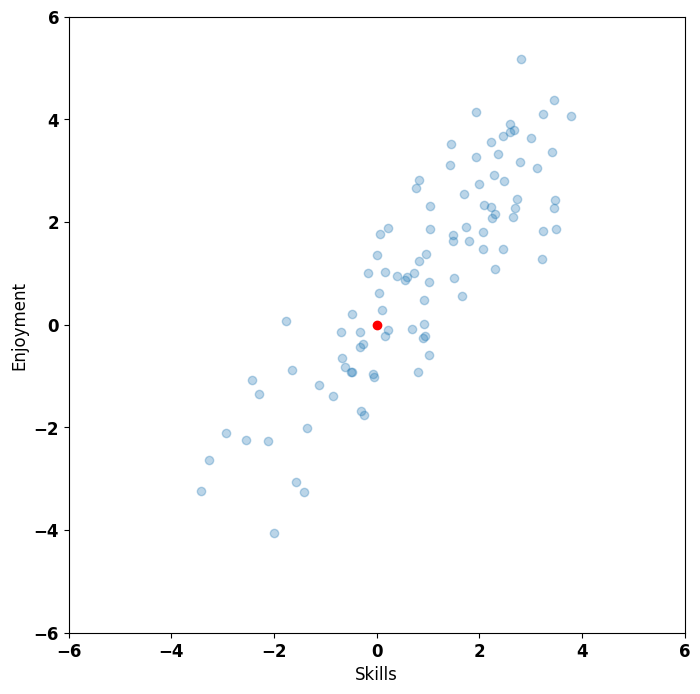

In [18]:
print(f'num of points {X.shape[0]} in dimension {X.shape[1]}')
fig = plt.figure(figsize=(8,8))
plt.scatter(*X.T, alpha=0.3)
plt.scatter(0, 0, c='red')
plt.ylabel('Enjoyment')
plt.xlabel('Skills')
plt.axis('scaled')
plt.xlim(-6, 6)
plt.ylim(-6, 6)

In [19]:
# standardize
center = X.mean(axis=0) #X shape is 100x2
std = X.std(axis=0)
Xp = (X-center)/std

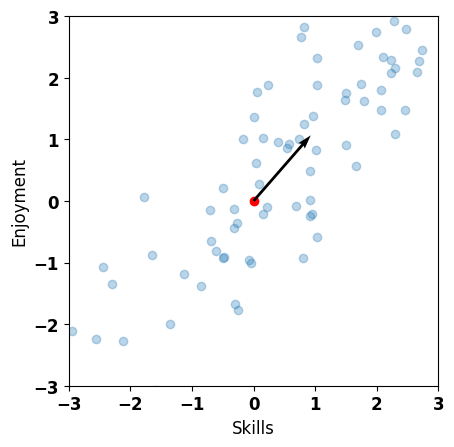

In [20]:
fig = plt.scatter(*X.T, alpha=0.3)
plt.scatter(0, 0, c='red')
plt.quiver(0, 0, *center, angles='xy', scale_units='xy', scale=1)
plt.ylabel('Enjoyment')
plt.xlabel('Skills')
plt.axis('scaled')
plt.xlim(-3, 3)
_=plt.ylim(-3, 3)
#print(center)  

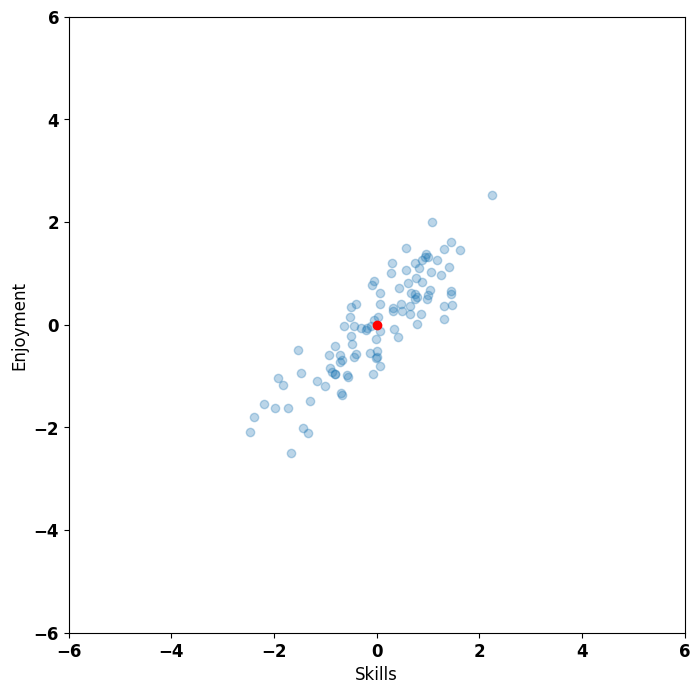

In [21]:
fig = plt.figure(figsize=(8,8))
plt.scatter(*Xp.T, alpha=0.3)
plt.scatter(0, 0, c = 'red')
plt.ylabel('Enjoyment')
plt.xlabel('Skills')
plt.axis('scaled')
plt.xlim(-6, 6)
_=plt.ylim(-6, 6)

In [22]:
C = np.cov(X, rowvar=False)
Sigma, U = np.linalg.eig(C)
# If rowvar is True (default), then each row represents a variable, 
# with observations in the columns. Otherwise, the relationship 
# is transposed: each column represents a variable, while the 
# rows contain observations.

In [23]:
C.shape

(2, 2)

In [24]:
Sigma.shape, U.shape, Sigma

((2,), (2, 2), array([0.47772418, 6.90110921]))

In [25]:
total_energy = Sigma.sum()
var_exp = Sigma/total_energy
cum_var_exp = np.cumsum(var_exp)

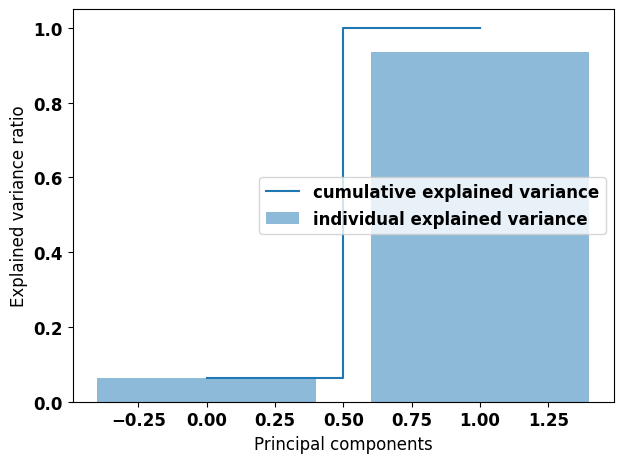

In [26]:
plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(len(var_exp)), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
Sigma = np.diag(Sigma)

# PCA for projecting/reconstructing data

$$ \text{eig}(\mathbf{C}) \rightarrow \mathbf{\Sigma},\mathbf{U} $$

$$ \mathbf{C} = \mathbf{U}\Sigma\mathbf{U}^T$$

$$ \mathbf{U}\Sigma\mathbf{U}^T =  \frac{1}{N} \mathbf{X}\mathbf{X}^T$$ 

$$ \mathbb{P}_{\mathbf{u}}\mathbf{x} = (\mathbf{x}\mathbf{u}^T)\mathbf{u}$$

# No compression, no rotation
Can be seen as reconstructing the data using **U**:
$$\underbrace{\mathbf{x}^T}_{2 \times N} = \underbrace{\mathbf{U}}_{2\times 2}\quad\underbrace{\mathbf{U}^T}_{2\times 2}\quad\underbrace{\mathbf{x}^T}_{2\times N}$$

In [27]:
# Full projection
print(U.shape, U.T.shape, Xp.T.shape)
Xd = U @ U.T @ Xp.T  # Our transformation
print(Xd.shape)

(2, 2) (2, 2) (2, 100)
(2, 100)


In [28]:
print('Sigma', Sigma, 'U', U, sep='\n\n')

Sigma

[[0.47772418 0.        ]
 [0.         6.90110921]]

U

[[-0.76738982 -0.64118083]
 [ 0.64118083 -0.76738982]]


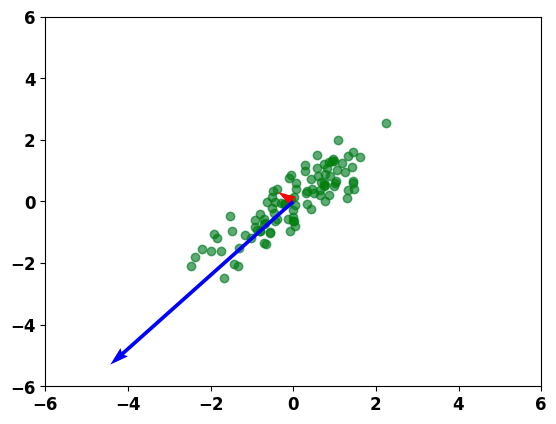

In [29]:
fig, ax = plt.subplots()
ax.scatter(*Xp.T,alpha=0.3)
ax.scatter(*Xd, color='green', alpha=0.5)
plt.xlim(-6,6)
plt.ylim(-6,6)
plotVectors(ax, [Sigma[0,0]*U[:,0], Sigma[1,1]*U[:,1]], cols=['red','blue'])

## What happens if we use only the first dominant basis (first component)?

In [30]:
Utrunc = U[:,1].reshape(2,-1) # need reshape for matrix mul.
# note [:,1] selects the eigenvector with more energy (highest eigen value)
# if you have more of them you have to sort, with 2 it is easier it is either this or the other
print()

In [31]:
# Compressed projection
print('Full projection>', U.shape, U.T.shape, Xp.T.shape)
print('Compressed projection>', Utrunc.shape, Utrunc.T.shape, Xp.T.shape)
Xd = Utrunc.T @ Xp.T  # Our transformation project down = Utrunc.T @ x.T;
print(Xd.shape)

Full projection> (2, 2) (2, 2) (2, 100)
Compressed projection> (2, 1) (1, 2) (2, 100)
(1, 100)


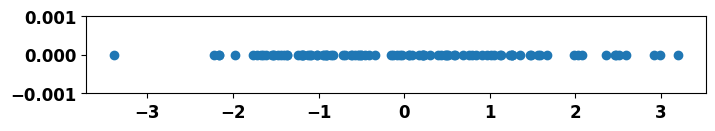

In [32]:
fig = plt.figure(figsize=(8,1))
plt.plot(Xd[0, ...].T, [0]*Xd.shape[1], 'o')
_ = plt.ylim(-0.001, 0.001)

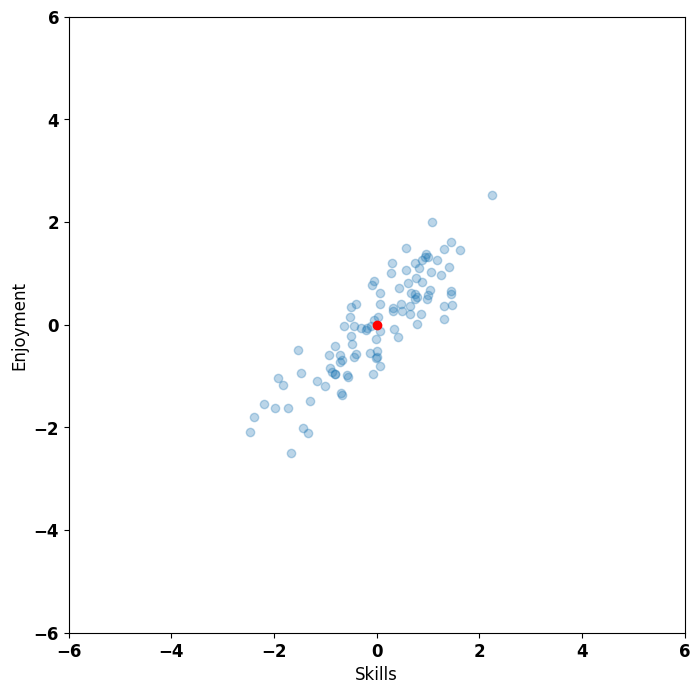

In [33]:
fig = plt.figure(figsize=(8,8))
plt.scatter(*Xp.T, alpha=0.3)
plt.scatter(0, 0, c = 'red')
plt.ylabel('Enjoyment')
plt.xlabel('Skills')
plt.axis('scaled')
plt.xlim(-6, 6)
_=plt.ylim(-6, 6)

In [34]:
# Compressed projection and back-projected
print(U.shape, U.T.shape, Xp.T.shape)
Xd = Utrunc @ Utrunc.T @ Xp.T  # Our transformation A = U @ Ut;
print(Xd.shape)

(2, 2) (2, 2) (2, 100)
(2, 100)


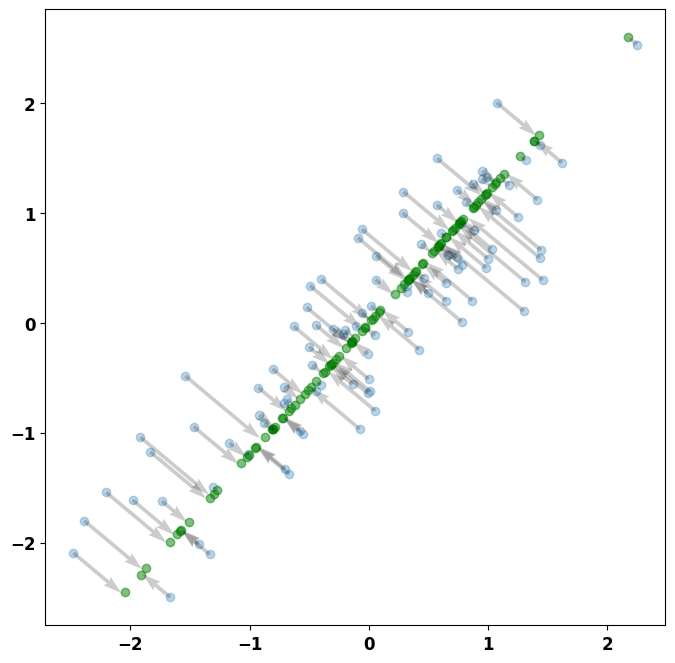

In [35]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.scatter(*Xp.T, alpha=0.3)
ax.scatter(*Xd, color='green', alpha=0.5)
_ = ax.quiver(*Xp.T, *(Xd-Xp.T), alpha=0.2, linestyle='dashed',
          linewidth=.4, color='black')  # start, end-start

## We have reduced the dimensionality of the data since we projected on a line

Can be used for compressing and reconstructing the data using **U** up to *k* components:
$$\underbrace{\mathbf{x}^T}_{\text{rec}} = \underbrace{\underbrace{\mathbf{U}_{|k}}_{k \mapsto D}\quad\underbrace{\underbrace{\mathbf{U}_{|k}^T}_{D \mapsto k}\quad\underbrace{\mathbf{x}^T}_{\text{orig}}}_{projection}}_{reconstruction}$$

# PCA Full recipe
$$ \mathbf{X}^{\prime} \leftarrow \frac{\mathbf{X} - \mathbf{\mu}}{\boldsymbol{\sigma}} $$

$$\underbrace{\mathbf{x}^{T\prime}_p}_{\text{rec}} = \underbrace{\underbrace{\mathbf{U}_{|k}}_{k \mapsto D}\quad\underbrace{\underbrace{\mathbf{U}_{|k}^T}_{D \mapsto k}\quad\underbrace{\mathbf{x}^{T\prime}}_{\text{orig}}}_{projection}}_{reconstruction}$$

$$ \mathbf{x}_p\leftarrow\left(\mathbf{x}^{T\prime}_p{\boldsymbol{\sigma}}\right)+\mathbf{\mu}$$

# Artificial Intelligence and Machine Learning <a class="tocSkip">


## Unit II <a class="tocSkip">

##  PCA in higher dimension, 3DMM, the curse of dimensionality

**Iacopo Masi**


# Recap previous lectures
- Vector and Matrix as a formal way to represent data
- Why LA? (data, covariance matrix, calculus)
- Operations (vector to vector, matrix to vector, inner product)
- Geometric Interpretation of the inner product
- Subspaces/Rank/Inverse
- Projection onto a subspace

# This lecture material is taken from
- ### Note: <ins> you can find PCA on Chapter 12 of [Bishop Book] </ins>
- [Geometry of the Transformations](https://en.wikipedia.org/wiki/Geometric_transformation)
- [Geometry of Transformations take 2](https://math.hmc.edu/calculus/hmc-mathematics-calculus-online-tutorials/linear-algebra/geometry-of-linear-transformations/)
- [This pdf covers this part](http://cs229.stanford.edu/summer2019/cs229-linalg.pdf)
- [Illustrations and some math parts are taken from d2l.ai, eigendecomposition](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/eigendecomposition.html)
- [Code for Eigendecomposition](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.7-Eigendecomposition/)

# Today's lecture
## Recall PCA (we use projection!) and Eigendecomposition
### Note: <ins> you can find PCA on Chapter 12 of [Bishop Book] </ins>
## Applications of PCA (3DMM)

# PCA Full recipe
$$ \mathbf{X}^{\prime} \leftarrow \frac{\mathbf{X} - \mathbf{\mu}}{\boldsymbol{\sigma}} $$

$$\underbrace{\mathbf{x}^{T\prime}_p}_{\text{rec}} = \underbrace{\underbrace{\mathbf{U}_{|k}}_{k \mapsto D}\quad\underbrace{\underbrace{\mathbf{U}_{|k}^T}_{D \mapsto k}\quad\underbrace{\mathbf{x}^{T\prime}}_{\text{orig}}}_{projection}}_{reconstruction}$$

$$ \mathbf{x}_p\leftarrow\left(\mathbf{x}^{T\prime}_p{\boldsymbol{\sigma}}\right)+\mathbf{\mu}$$

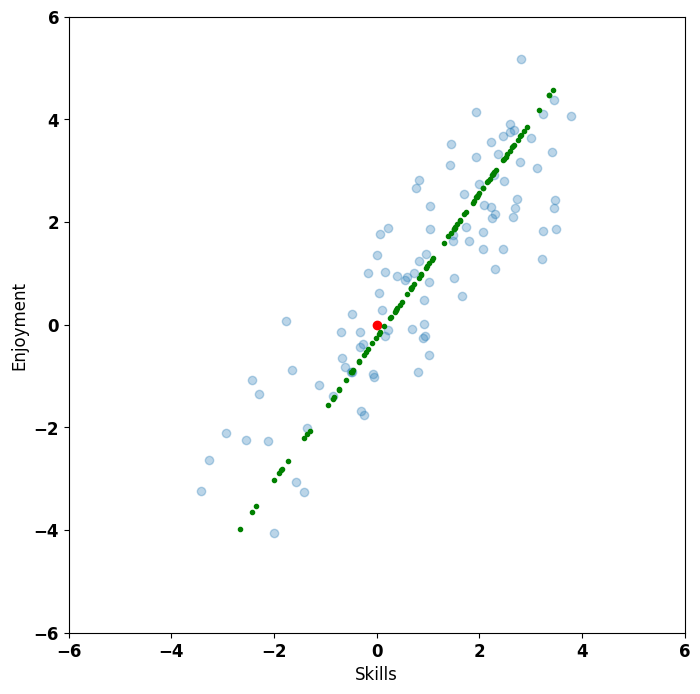

In [36]:
########################################
plt.figure(figsize=(8,8))
plt.scatter(*X.T, alpha=0.3)
plt.scatter(0, 0, c='red')
plt.ylabel('Enjoyment')
plt.xlabel('Skills')
plt.axis('scaled')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
# Taking reconstructed data and shift it back
###############################
Xd_back = (Xd.T*std)+center
#########################
plt.scatter(*Xd_back.T, color='green', marker='.')

# Application: PCA to rotate data (make it axis aligned), decorrelate data

## in unsupervised way

- For reading images there are multiple library
- One is Pillow `conda install pillow` or `pip install pillow`

In [37]:
from PIL import Image
import requests
from io import BytesIO

#response = requests.get('https://cdn-icons-png.flaticon.com/512/24/24335.png')
img = Image.open('figs/italy.png')
im = np.array(img)

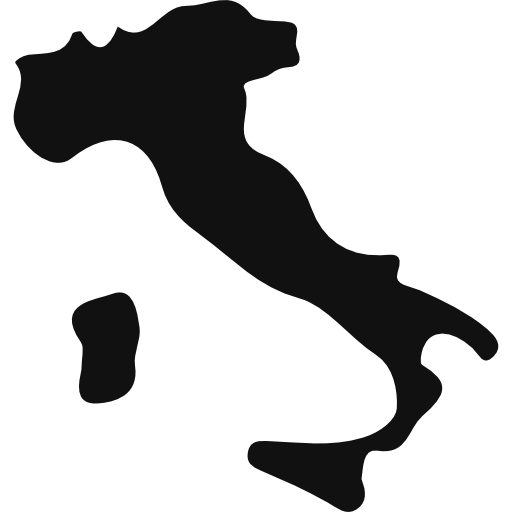

In [38]:
img

In [39]:
X, Y = np.where(im != 0)
sampling = 100  # to have less points
X, Y = X[::sampling], Y[::sampling]

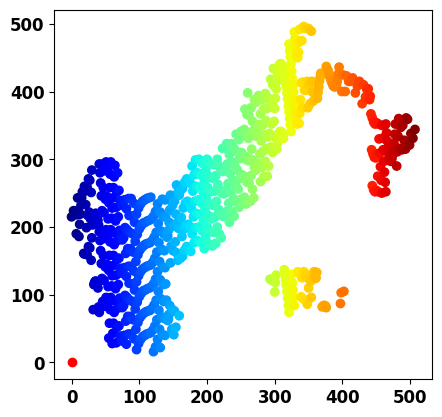

In [40]:
fig = plt.scatter(X, Y, c=X, marker='o', cmap='jet')
plt.scatter(0, 0, c='red')
_ = plt.axis('scaled')

# PCA Application - Rotate the data and decorrelate them - No compression

$$ \mathbf{X}^{\prime} \leftarrow \frac{\mathbf{X} - \mathbf{\mu}}{\mathbf{\sigma}} $$

$$\underbrace{\mathbf{x}^{T\prime}_p}_{\text{rot}} = {\mathbf{U}^T}\quad\underbrace{\mathbf{x}^{T\prime}}_{\text{orig}}$$

$$ \text{Optional:}~~~~ \mathbf{x}_p\leftarrow\left(\mathbf{x}^{T\prime}_p{\mathbf{\sigma}}\right)+\mathbf{\mu}$$

In [41]:
pts = np.stack((X, Y), axis=1)
# Nx2
print(f'num of points {pts.shape[0]} in dimension {pts.shape[1]}' )

num of points 746 in dimension 2


In [42]:
# Standardize the data 
# (x-mu)/sigma
center = pts.mean(axis=0)
std = pts.std(axis=0)
pts_z = (pts - center)/std

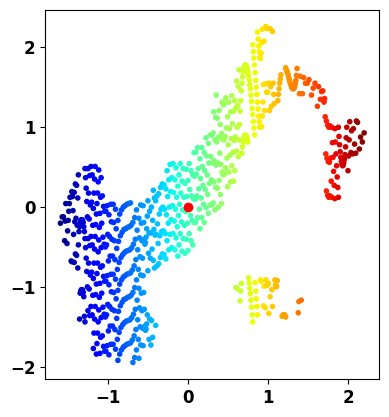

In [43]:
fig = plt.scatter(*pts_z.T, c=X, marker='.', cmap='jet')
plt.scatter(0,0,c='red')
_ = plt.axis('scaled')

In [44]:
# np.cov wants features on rows
cov = np.cov(pts_z, rowvar=False)
Sigma, U = np.linalg.eig(cov)

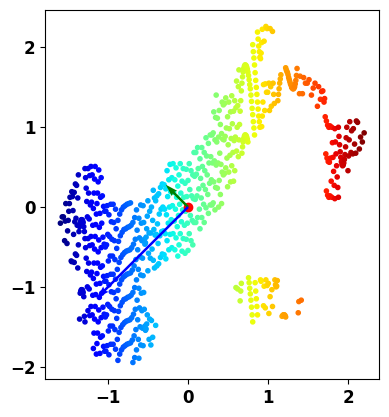

In [45]:
# plot principal components aka eigenvectors
fig = plt.scatter(*pts_z.T, c=X, marker='.', cmap='jet')
plt.scatter(0,0,c='red')
plotVectors(fig.axes, [Sigma[0]*U[:,0], Sigma[1]*U[:,1]], cols=['green','blue'])
_ = plt.axis('scaled')

In [46]:
# rotate points
rot = U.T@pts_z.T
np.cov(rot,rowvar=True)

array([[ 3.95280931e-01, -2.78971477e-16],
       [-2.78971477e-16,  1.60740363e+00]])

(-3.0, 3.0)

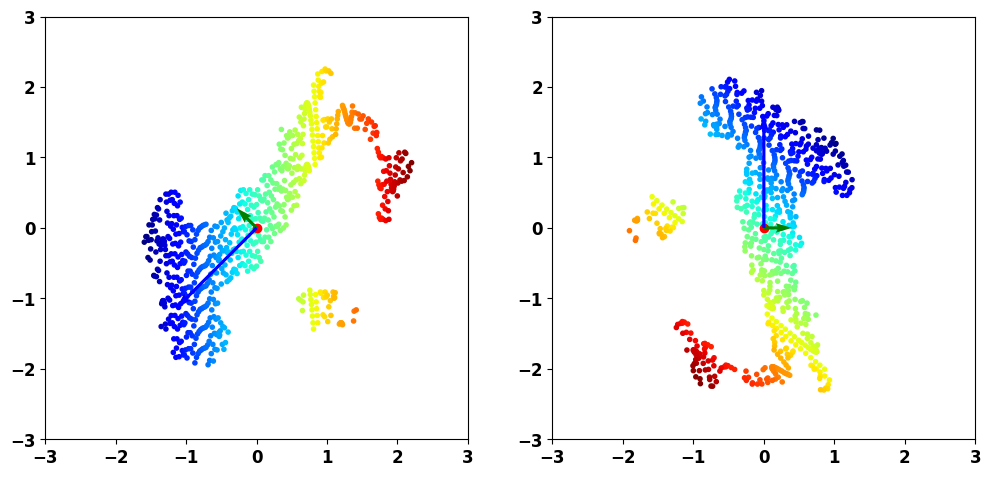

In [47]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(12)
fig.set_figwidth(12)
# First
ax[0].scatter(*pts_z.T, c=X, marker='.', cmap='jet')
ax[0].scatter(0,0,c='red')
plotVectors(ax[0], [Sigma[0]*U[:,0], Sigma[1]*U[:,1]], cols=['green','blue'])
ax[0].set_aspect('equal')
ax[0].set_xlim(-3,3)
ax[0].set_ylim(-3,3)
# second
ax[1].scatter(*rot, c=X, marker='.', cmap='jet')
ax[1].scatter(0,0,c='red')
plotVectors(ax[1], [Sigma[0]*np.array([1,0]), Sigma[1]*np.array([0,1])], cols=['green','blue'])
ax[1].set_aspect('equal')
ax[1].set_xlim(-3,3)
ax[1].set_ylim(-3,3)

In [48]:
np.set_printoptions(suppress=True) #suppress scientific notation, please watch out using this
np.cov(rot, rowvar=True) # rowvar is True because matrix is 2xN
# do you know why we get this? and what are the values inside?

array([[ 0.39528093, -0.        ],
       [-0.        ,  1.60740363]])

# Application: Data whitening

What does it mean whitening or sphering?



# Do you remember this?

<br>
<img width="75%" src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/1920px-Correlation_examples2.svg.png" />


<small>Graphics from Wikipedia</small>

# PCA Application - Whitening - No compression

$$ \mathbf{X}^{\prime} \leftarrow \frac{\mathbf{X} - \mathbf{\mu}}{\mathbf{\sigma}} $$

$$\underbrace{\mathbf{x}^{T\prime}_p}_{\text{dec.}} = {\mathbf{\Sigma}^{-1/2}\mathbf{U}^T}\quad\underbrace{\mathbf{x}^{T\prime}}_{\text{orig}}$$


In [49]:
Sigma_inv_sqrt = np.diag(Sigma**-0.5)
# data is rotated and decorrelated (whitening or sphering)
rot_withening = Sigma_inv_sqrt @ U.T @ pts_z.T

(-3.0, 3.0)

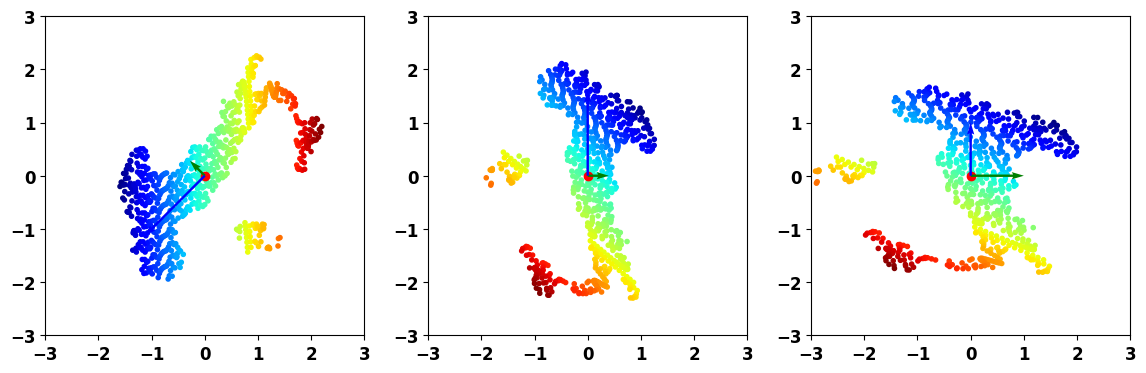

In [50]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(14)
fig.set_figwidth(14)
# First
ax[0].scatter(*pts_z.T, c=X, marker='.', cmap='jet')
ax[0].scatter(0,0,c='red')
plotVectors(ax[0], [Sigma[0]*U[:,0], Sigma[1]*U[:,1]], cols=['green','blue'])
ax[0].set_aspect('equal')
ax[0].set_xlim(-3,3)
ax[0].set_ylim(-3,3)
# second
ax[1].scatter(*rot, c=X, marker='.', cmap='jet')
ax[1].scatter(0,0,c='red')
plotVectors(ax[1], [Sigma[0]*np.array([1,0]), Sigma[1]*np.array([0,1])], cols=['green','blue'])
ax[1].set_aspect('equal')
ax[1].set_xlim(-3,3)
ax[1].set_ylim(-3,3)
# third
ax[2].scatter(*rot_withening, c=X, marker='.', cmap='jet')
ax[2].scatter(0,0,c='red')
plotVectors(ax[2], [np.array([1,0]), 
                    np.array([0,1])], cols=['green','blue'])
ax[2].set_aspect('equal')
ax[2].set_xlim(-3,3)
ax[2].set_ylim(-3,3)

(-3.0, 3.0)

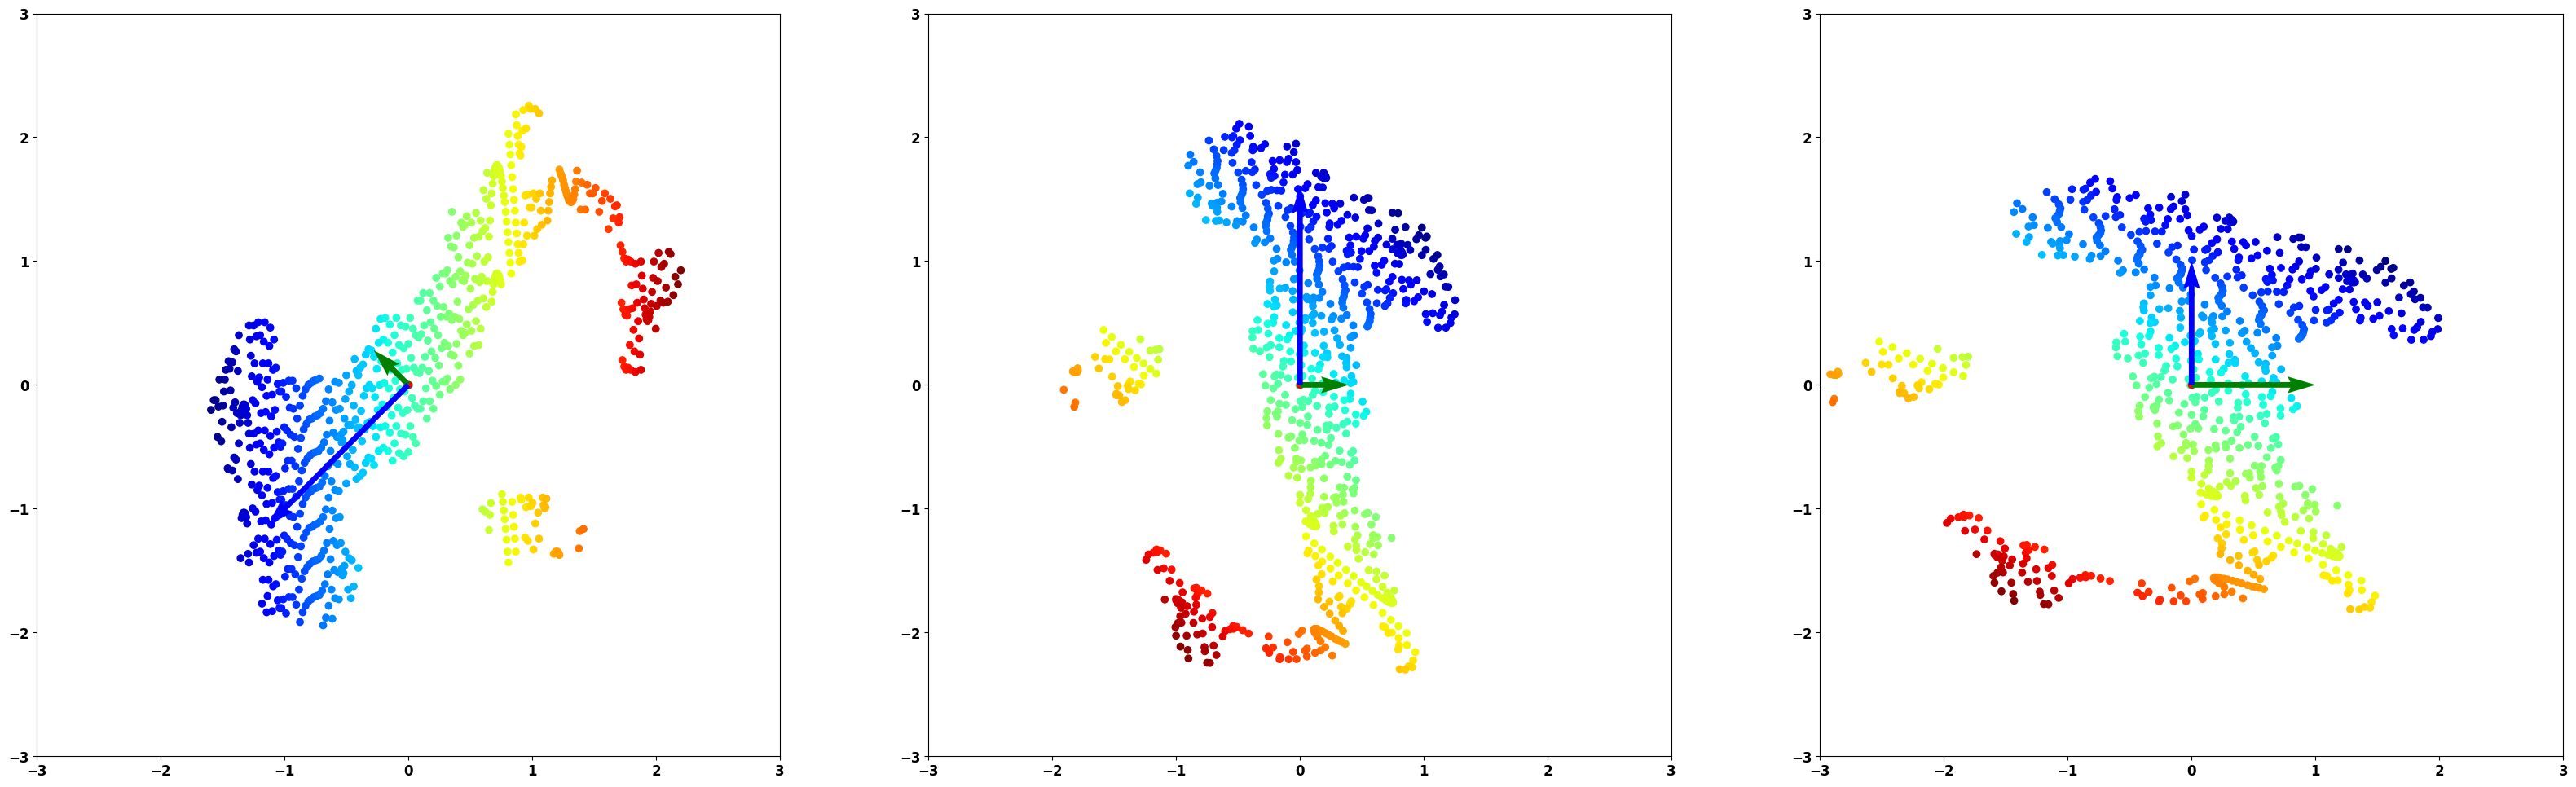

In [51]:
fig, ax = plt.subplots(1,3); sizeim=40;
fig.set_figheight(sizeim)
fig.set_figwidth(sizeim)
# First
ax[0].scatter(*pts_z.T, c=X, marker='o', cmap='jet')
ax[0].scatter(0,0,c='red')
plotVectors(ax[0], [Sigma[0]*U[:,0], Sigma[1]*U[:,1]], cols=['green','blue'])
ax[0].set_aspect('equal')
ax[0].set_xlim(-3,3)
ax[0].set_ylim(-3,3)
# second
ax[1].scatter(*rot, c=X, marker='o', cmap='jet')
ax[1].scatter(0,0,c='red')
plotVectors(ax[1], [Sigma[0]*np.array([1,0]), Sigma[1]*np.array([0,1])], cols=['green','blue'])
ax[1].set_aspect('equal')
ax[1].set_xlim(-3,3)
ax[1].set_ylim(-3,3)
# third
ax[2].scatter(*rot_withening, c=X, marker='o', cmap='jet')
ax[2].scatter(0,0,c='red')
plotVectors(ax[2], [np.array([1,0]), 
                    np.array([0,1])], cols=['green','blue'])
ax[2].set_aspect('equal')
ax[2].set_xlim(-3,3)
ax[2].set_ylim(-3,3)

# Sanity Check

We take the decorrelated data points and compute the covariance matrix:

$$\mathbf{X}_p\mathbf{X}_p^T$$

if **decorrelated** should get us:

$$
\begin{bmatrix}
1 & 0 \\
0 & 1 
\end{bmatrix}
$$
and in more dimensions should give us $\mathbf{I}$ matrix (identity matrix)

In [52]:
np.cov(rot_withening, rowvar=True) # rowvar is True becausse matrix is 2xN

array([[ 1., -0.],
       [-0.,  1.]])

We can also "prove" it that induced decorrelated and "sphered" points:

$$\underbrace{\mathbf{x}^{T\prime}_p}_{\text{dec.}} = {\mathbf{\Sigma}^{-1/2}\mathbf{U}^T}\quad\underbrace{\mathbf{x}^{T\prime}}_{\text{orig}}$$

# Sphering vs Standardization 

<br><img src="https://jermwatt.github.io/machine_learning_refined/mlrefined_images/unsupervised_images/standard_normal_vs_pca_sphereing.png" width='70%' />

# PCA in Computer Graphics: 3D Morphable Models (3DMM)

- A set of 3D faces point cloud matrix $\mathbf{X}=\{\mathbf{S}_i\}_{i=1}^M$ with $\mathbf{S}_i \in \mathbf{R}^{3N}$ and $M$ are the samples we have.
-  $\mathbf{S}_i = [x_1,y_1,z_1,\ldots,x_N,y_N,z_N,]$ point cloud stack in a vector.
- **Assumption**: The point cloud is **vertex-aligned** (usually this implies dense registration, not easy to achieve)
- **Assumption**: $\mathbf{S}\sim\mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$ faces are modeled as a multivariate Gaussian distribution.
<img widthg="60%" src="figs/3dmm.png" />

Figure Credit [3DMM, Past Present and Future](https://arxiv.org/pdf/1909.01815.pdf)

<img width='50%' src="figs/3dmm_synthesis.png" />

Credits [Blanz and Vetter, 1999](https://gravis.dmi.unibas.ch/publications/Sigg99/morphmod2.pdf)

# 3D Face modeling with PCA

$ \mbf{S}^{\prime} = \mbf{\hat{S}} + \sum_{i}^{M-1} \alpha_i \mbf{U}_i $ where:
- $ \mbf{\hat{S}} $ is the mean shape
- and $\mbf{U}_i$ are the $M-1$ principal components that you can compute by learning PCA on $\mbf{X}=\{\mbf{S}_i\}_{i=1}^M$

## A (new) 3D face is defined once you know $\mbf{\alpha}$

- $ \mbf{\alpha} = [\alpha_1,\ldots,\alpha_k]$ scales each principal component
- Similar to say:
    - OK, this is the average face (fixed for everyone)
    - but I want to edit the average to add `0.25 * male (1st component)` +  `-0.12 * caucasian (2nd component)` + `...`

# 3D Face modeling with PCA

$ \mbf{S}^{\prime} = \mbf{\hat{S}} + \sum_{i}^{M-1} \alpha_i \mbf{U}_i $ where:

PCA assumes the data generation process is a **multivariate Gaussian distribution (i.e. a Gaussian/Normal distribution but in 3N-D).**

$
 \underbrace{\{\mathbf{S}_i\}_{i=1}^M}_{\text{known}}  \sim \underbrace{\mathcal{N}(\mbf{\hat{S}},\mbf{Cov}_S)}_{\text{multivariate Gaussian assumption}} \approx \underbrace{\mathcal{D}}_{\text{unknown}}
$

- Given a face $\mbf{\alpha} = [\alpha_1,\ldots,\alpha_k]$ you can compute how much it is likely of "being a face" under $\mathcal{N}(\mbf{\hat{S}},\mbf{Cov}_S)$
- $\mbf{\alpha} = [0.2,\ldots,0.24]$ is **more probable** of being a face (you get something **regular**)
- $\mbf{\alpha} = [0.1,\ldots,-1.24]$ is **less probable** of being a face (you get something **irregular**)

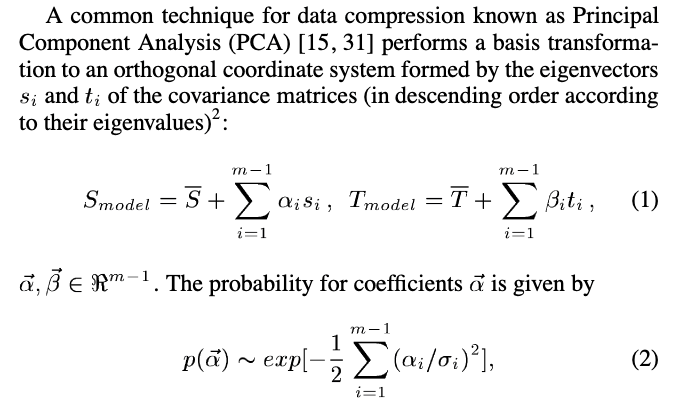

<video width="80%" controls src="figs/ICPR14.mov" />

## Principal Components refers to Variations in Faces 
- 1st component: gender or age (most variation)
- 2nd component: face size (moderate variation)
- .....
- last component: nose size etc (least variation)

<img width="70%" src="figs/3dmm_components.png" />

Figure credit [Booth et al. 3DMM in the Wild](https://arxiv.org/pdf/1701.05360.pdf)

[Click here for interactive demo - FLAME - Max Planck](https://flame.is.tue.mpg.de/interactivemodelviewer.html)

# Expressiveness

$\mbf{S}^{\prime} = \mbf{\hat{S}} + \sum_{i}^{M-1} \alpha_i \mbf{U}_i$ where:
- $ \mbf{\hat{S}} $ is the mean shape
- and $\mbf{U}_i$ are the $ M-1 $ principal components that you can compute by learning PCA on $\mbf{X}=\{\mbf{S}_i\}_{i=1}^M$.

# Part-based 3DMM

- The expressiveness of the model can be increased by dividing faces into **independent sub-regions** that are morphed independently, for example into eyes, nose, mouth and a surrounding region.
- Since **all faces are assumed to be in correspondence**, it is sufficient to define these regions on a reference face. This segmentation is equivalent to sub-dividing the vector space of faces into **independent subspaces**. 
- A complete 3D face is generated by computing linear combinations for each segment separately and **blending** them at the borders according to an algorithm proposed for images by a blending algorithm

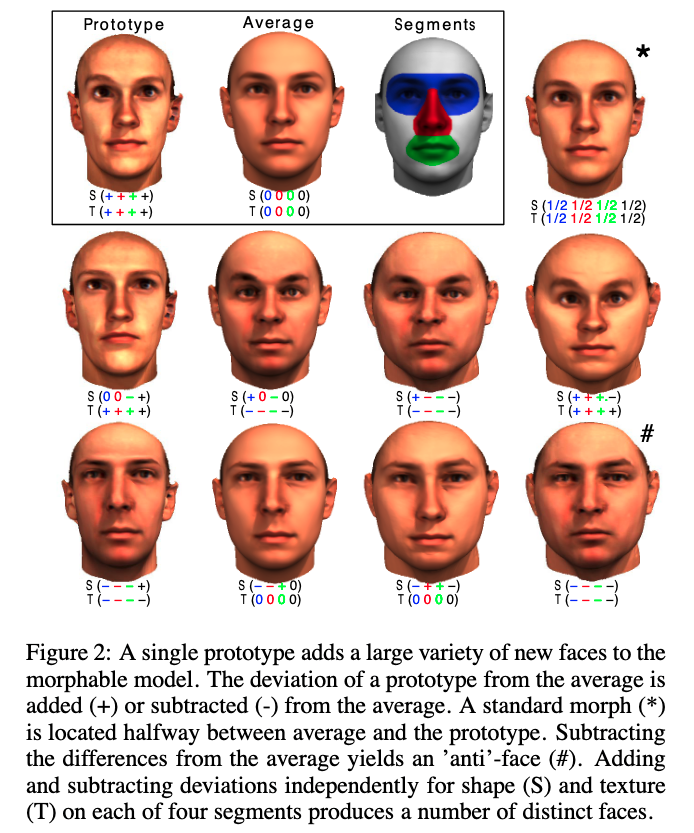

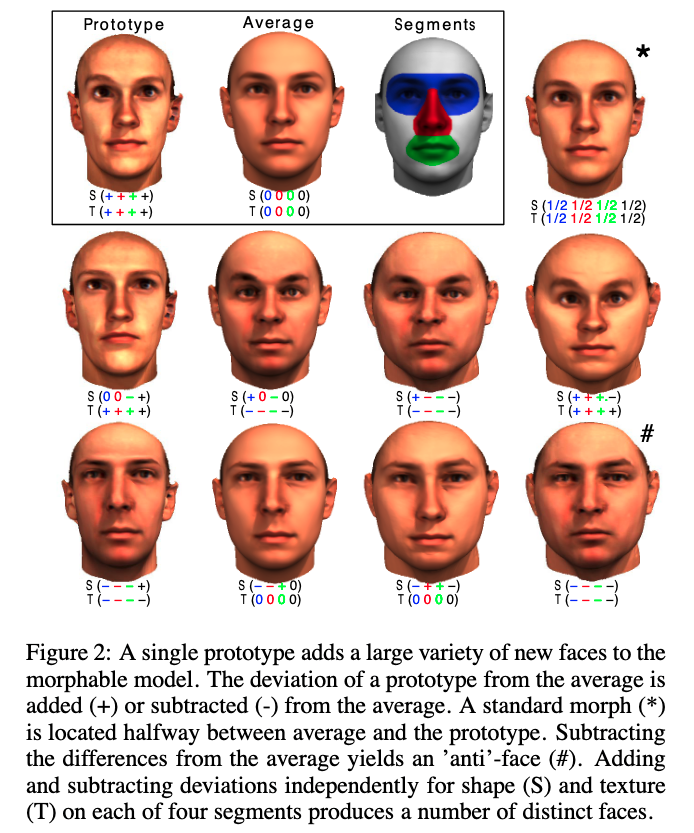

# Two more real world examples

[Morphable Models are everywhere - Snapfeet App](https://snapfeet.io/en/footcompass/)

[Body Morphable Models @ Max Planck Institute for Intelligent Systems](https://bodytalk.is.tue.mpg.de/)

# Up next: PCA in High Dimensional Space


- Demonstration with images
- You can think of an image $\mathbf{I}\in \mathbb{R}^{W\times H}$ as a point/vector in high dimension.
- For an image $128\times 128$ now our $D$ dimension is very high. $D=128^2=(2^7)^2=2^{14}\approx16K$

- Let's double the image $128 \mapsto 256$

- For an image $256\times 256$ now our $D$ dimension is very high. $D=256^2=(2^8)^2=2^{16}\approx65K$
- Doubling a side, increases the dimension four times, for two-dimensional nature of images.

# PCA is in sklearn but implementing it manually is for understanding

```python
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
```

## In case you have to use it in industry/thesis, you will rely on `sklearn`
## i.e. "not reinventing the wheel" but academically it is good to do it manually